In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one_100, solve_smooth_unreveal, generate_weight, solve_smooth_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False

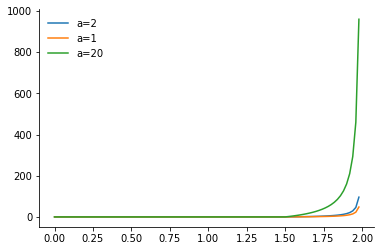

In [3]:
a = 2
y_grid_cap = np.arange(0, 2 + 0.02, 0.02)
func2 = (2/(2 - y_grid_cap[:-1] ) - 2/(2-1.5))*(y_grid_cap[:-1]>=1.5)
func1 = (1/(2 - y_grid_cap[:-1] ) - 1/(2-1.5))*(y_grid_cap[:-1]>=1.5)
func20 = (20/(2 - y_grid_cap[:-1] ) - 20/(2-1.5))*(y_grid_cap[:-1]>=1.5)
plt.plot(y_grid_cap[:-1],func2, label="a=2")
plt.plot(y_grid_cap[:-1],func1, label="a=1")
plt.plot(y_grid_cap[:-1],func20, label="a=20")
plt.legend()

In [2]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
ς = 0.1
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0, 1/3, 2)
# capital parameters
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [3]:
# γ3_list_test = γ3_list[[0,1,2,-1]]
# γ3_list = γ3_list_test

In [3]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

In [4]:
from multiprocessing import Pool
ξa = 0.01
ξw = 100000
ξp = 5
dmg_weight = np.ones(len(γ3_list))/len(γ3_list)

hy = 0.02
y_bar =2
y_min = 0
y_max = 4
y_lower = 1.5

jump_interval = np.arange(y_lower,y_bar+hy, hy)
y_grid = np.arange(y_min, y_max+hy, hy)

In [22]:
args_low = (δ, η, θ_list, σy, γ1, γ2, γ3_list[0], 2, ξa, ξw )
solution_low = solve_smooth_100(y_grid, args_low, max_iter=5000, tol=1e-7, ϵ=0.5,)

episode: 5000,	 ode error: 0.00037728350639623653,	 ft error: 0.00016525157220925735


In [8]:
args_list = []
for y_tilde in jump_interval:
    for γ3_i in γ3_list[1:]:
        args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, y_tilde, ξa, ξw )
        args_iter = (y_grid, args_func, 5000, 1e-7, 0.5)
        args_list.append(args_iter)

def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_smooth_100, args_list)
    return res_list        
#         ϕ, ems, _, _ = solve_smooth_100()
#         ϕ_list.append(ϕ)
#         e_list.append(ems)
#     ϕ_list = np.array(ϕ_list)
#     e_list = np.array(e_list)
#     res_list.append((ϕ_list, e_list))

In [9]:
import time
start = time.time()
res_list = ode_y_parallel(args_list)
time.strftime("%Hh%Mm%Ss", time.gmtime(time.time()-start))

episode: 2433,	 ode error: 0.00025184937058989054,	 ft error: 9.978877801852803e-08
episode: 2679,	 ode error: 0.000549758824288045,	 ft error: 9.981084758692305e-08
episode: 2683,	 ode error: 0.000564088258230934,	 ft error: 9.960132274500211e-08
episode: 2501,	 ode error: 0.00023304680467108735,	 ft error: 9.994464678086956e-08
episode: 2675,	 ode error: 0.0005351792552360582,	 ft error: 9.992848681861233e-08
episode: 2602,	 ode error: 0.00032573422613314806,	 ft error: 9.991067084769156e-08
episode: 2543,	 ode error: 0.0002796782636365347,	 ft error: 9.981685167304022e-08
episode: 2550,	 ode error: 0.0002949205380490816,	 ft error: 9.982420223764166e-08
episode: 2657,	 ode error: 0.00047785931163019796,	 ft error: 9.963242852961685e-08
episode: 2651,	 ode error: 0.000456930580036978,	 ft error: 9.984824878017662e-08
episode: 2572,	 ode error: 0.00032501690017415485,	 ft error: 9.98656730644143e-08
episode: 2637,	 ode error: 0.00041004303785057566,	 ft error: 9.99529259360088e-08
epi

episode: 2725,	 ode error: 0.0007284060302342119,	 ft error: 9.99116416267043e-08
episode: 2709,	 ode error: 0.0006668320764106131,	 ft error: 9.984113269467798e-08
episode: 2724,	 ode error: 0.0007168010516223171,	 ft error: 9.96929667707036e-08
episode: 2438,	 ode error: 0.00025495877249750304,	 ft error: 9.960753211135653e-08
episode: 2735,	 ode error: 0.0007534415281890278,	 ft error: 9.96646711826088e-08
episode: 2700,	 ode error: 0.0006154311547792064,	 ft error: 9.9806246822709e-08
episode: 2645,	 ode error: 0.00043434139557343987,	 ft error: 9.956053226289896e-08
episode: 2644,	 ode error: 0.00043427693132339074,	 ft error: 9.993525829088412e-08
episode: 2703,	 ode error: 0.0006284356821142992,	 ft error: 9.95466749031948e-08
episode: 2727,	 ode error: 0.0007399585005781993,	 ft error: 9.959738989095968e-08
episode: 2675,	 ode error: 0.0005394895473012015,	 ft error: 9.972245429423765e-08
episode: 2721,	 ode error: 0.0006933834881893593,	 ft error: 9.963980751592771e-08
episode

episode: 2696,	 ode error: 0.0006483818828868573,	 ft error: 9.968609404609197e-08
episode: 2726,	 ode error: 0.0007458404935626294,	 ft error: 9.95366704614753e-08
episode: 2715,	 ode error: 0.0007276453482097482,	 ft error: 9.970652392610191e-08
episode: 2685,	 ode error: 0.0005885196989926789,	 ft error: 9.972964853943722e-08
episode: 2574,	 ode error: 0.0002948104456246825,	 ft error: 9.962045499634087e-08
episode: 2712,	 ode error: 0.0006986363830589343,	 ft error: 9.973685166642099e-08
episode: 2614,	 ode error: 0.0003543936655209731,	 ft error: 9.969097458650822e-08
episode: 2710,	 ode error: 0.0006858966712728724,	 ft error: 9.981144266646425e-08
episode: 2670,	 ode error: 0.0005374919607056931,	 ft error: 9.98208271596468e-08
episode: 2656,	 ode error: 0.00047902055993743337,	 ft error: 9.98602089907763e-08
episode: 2625,	 ode error: 0.0003818534607506127,	 ft error: 9.957199775811887e-08
episode: 2727,	 ode error: 0.0007575517980378289,	 ft error: 9.968260883397306e-08
episod

episode: 2641,	 ode error: 0.00043236744476652517,	 ft error: 9.981859960817019e-08
episode: 2539,	 ode error: 0.0002893619683579443,	 ft error: 9.977087112034155e-08
episode: 2705,	 ode error: 0.0007106849596671266,	 ft error: 9.953129342932243e-08
episode: 2684,	 ode error: 0.0006095453742827051,	 ft error: 9.982032800337493e-08
episode: 2654,	 ode error: 0.0004784871454712944,	 ft error: 9.974831627346248e-08
episode: 2582,	 ode error: 0.00029378670037442933,	 ft error: 9.978773540808561e-08
episode: 2718,	 ode error: 0.0007571219449925524,	 ft error: 9.95400881720343e-08
episode: 2648,	 ode error: 0.000456065477542969,	 ft error: 9.97911886457814e-08
episode: 2701,	 ode error: 0.0006730638300524831,	 ft error: 9.965766878394788e-08
episode: 2633,	 ode error: 0.0004077564909082468,	 ft error: 9.99917215693813e-08
episode: 2634,	 ode error: 0.0004079681026109838,	 ft error: 9.964889358116125e-08
episode: 2716,	 ode error: 0.0007404031850147472,	 ft error: 9.999806671601164e-08
episod

episode: 2677,	 ode error: 0.0005771887088795238,	 ft error: 9.997864403032963e-08episode: 2709,	 ode error: 0.0007349787053365399,	 ft error: 9.957408053651307e-08

episode: 2669,	 ode error: 0.0005410314194360354,	 ft error: 9.968821323980137e-08
episode: 2690,	 ode error: 0.0006419025815616944,	 ft error: 9.979404858029284e-08
episode: 2716,	 ode error: 0.0007694018322892231,	 ft error: 9.999410366390293e-08
episode: 2696,	 ode error: 0.000674849864607769,	 ft error: 9.967349257067326e-08
episode: 2709,	 ode error: 0.0007385634481156741,	 ft error: 9.955590485333232e-08
episode: 2713,	 ode error: 0.0007700483429305752,	 ft error: 9.971115488838223e-08
episode: 2621,	 ode error: 0.000379097943732698,	 ft error: 9.967852321324244e-08
episode: 5000,	 ode error: 0.00027793091242987733,	 ft error: 1.3837839493824333e-05
episode: 2723,	 ode error: 0.0008088722085109745,	 ft error: 9.980419690691633e-08
episode: 2673,	 ode error: 0.0005604775255176227,	 ft error: 9.978696624557415e-08
epis

episode: 2664,	 ode error: 0.0005203803070826102,	 ft error: 9.969881098470523e-08
episode: 2710,	 ode error: 0.0006391631057168744,	 ft error: 9.960394287134022e-08
episode: 2659,	 ode error: 0.0004997202458997228,	 ft error: 9.97866393959157e-08
episode: 2581,	 ode error: 0.0002931829703337191,	 ft error: 9.97804630031851e-08
episode: 2709,	 ode error: 0.0007454661027057503,	 ft error: 9.971391357055381e-08
episode: 2668,	 ode error: 0.0005487066692001358,	 ft error: 9.977706127983765e-08
episode: 2607,	 ode error: 0.0005486052968529352,	 ft error: 9.978240456121057e-08
episode: 2687,	 ode error: 0.0006283877428573358,	 ft error: 9.986528226590963e-08
episode: 2723,	 ode error: 0.0008273248416034475,	 ft error: 9.951857116163865e-08
episode: 2724,	 ode error: 0.0008408901877877198,	 ft error: 9.990907123835768e-08
episode: 2721,	 ode error: 0.0008092867187139002,	 ft error: 9.97382496592536e-08
episode: 2726,	 ode error: 0.0008456356907764716,	 ft error: 9.96455327140211e-08
episode:

'01h24m39s'

In [214]:
res_dict = pickle.load(open('../data/damage_prep_40_tight.p', 'rb'))

ϕ_ref = res_dict['φ_ref']
ems_ref = res_dict['ems_ref']
res_list = res_dict['res_list']

In [215]:
y_grid[len(prepre_jump)]

1.5

In [19]:
# construct ϕ_m
pre_jump = np.arange(y_min, y_bar+hy, hy)
prepre_jump = np.arange(y_min, y_lower, hy)

In [470]:
ϕ_ref = np.zeros((len(γ3_list), len(pre_jump)))
ems_ref = np.zeros((len(γ3_list), len(pre_jump)))

count = 0
for i, y_tilde in enumerate(jump_interval):
    ϕ_ref[0, i + len(prepre_jump)] = solution_low['φ'][i+len(prepre_jump)] 
    ems_ref[0, i + len(prepre_jump)] = solution_low['ems'][i + len(prepre_jump)]
    for j in range(len(γ3_list[1:])):
        ϕ_ref[j+1, i + len(prepre_jump)] = res_list[i*len(γ3_list[1:]) + j]['φ'][i + len(prepre_jump)]
        ems_ref[j+1, i + len(prepre_jump)] = res_list[i*len(γ3_list[1:]) + j]['ems'][i + len(prepre_jump)]

In [23]:
ϕ_list = np.zeros((len(jump_interval), len(γ3_list), len(y_grid)))
ems_list = np.zeros((len(jump_interval), len(γ3_list), len(y_grid)))
for i, y_tilde in enumerate(jump_interval):
    ϕ_list[i, 0] = solution_low['φ']
    ems_list[i, 0] = solution_low['ems']
    for j in range(len(γ3_list[1:])):
        ϕ_list[i, j + 1] = res_list[i*len(γ3_list[1:]) + j]['φ']
        ems_list[i, j + 1] = res_list[i*len(γ3_list[1:]) + j]['ems']

In [472]:
res_dict = dict(res_list=res_list, ϕ_ref=ϕ_ref, ems_ref=ems_ref, ϕ_list=ϕ_list, ems_list=ems_list)
pickle.dump(res_dict, open("../data/damage_prep_40_tight.p", "wb"))

In [24]:
len(res_list)/39

26.0

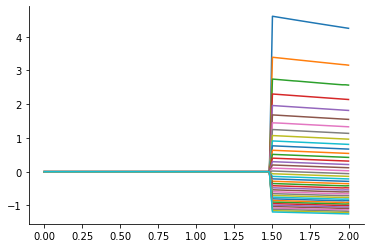

In [216]:
plt.plot(y_grid_cap,ϕ_ref.T)
plt.show()

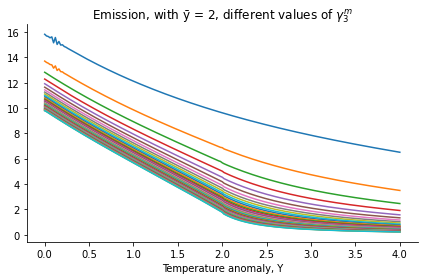

In [217]:
for i in range(len(dmg_weight)):
    plt.plot(y_grid,ems_list[-1, i, :])
plt.xlabel('Temperature anomaly, Y')
plt.title("Emission, with ȳ = 2, different values of $\gamma_3^m$")
plt.tight_layout()
# plt.savefig("ems.pdf", facecolor="w", edgecolor="w")
plt.show()

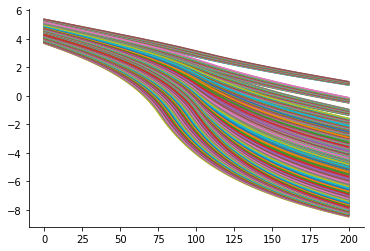

In [218]:
for i in range(len(res_list)):
    plt.plot(res_list[i]['φ'])

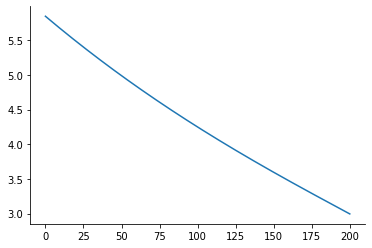

In [219]:
plt.plot(solution_low['φ'])

In [220]:
ϕ_ref.shape

(40, 101)

In [16]:
weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)

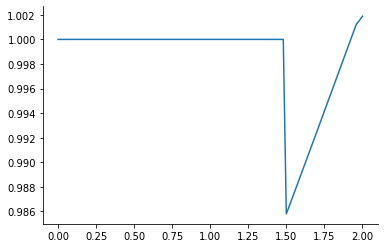

In [28]:
plt.plot(y_grid_cap, weighted)

In [29]:
from sympy.solvers import solve
from sympy import Symbol
x = Symbol('x')
ans = solve(x**3 + x**2 + x - 1, x)
r1 =np.log( float(ans[-1]))*2/(0.5/2)**2
# r0 = 1/(float(ans[-1])**4 - 1)/τ
r0 = - 0.4

In [30]:
r0, r1

(-0.4, -19.5000916299522)

In [31]:
numy_bar = len(pre_jump)-1
y_grid[:numy_bar+1]

array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  ])

In [32]:
ϕ_low = solution_low['φ']
ϕ_list_no_low = np.zeros((len(γ3_list[1:]), len(ϕ_low)))
for i in range(len(γ3_list[1:])):
    ϕ_list_no_low[i] = res_list[-(len(γ3_list[1:]) - i)]['φ']

In [33]:
ϕ_list_no_low.shape

(39, 201)

In [34]:
ϕ_list2 = np.concatenate(([ϕ_low], ϕ_list_no_low), axis=0)

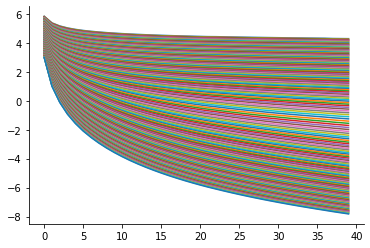

In [35]:
plt.plot(ϕ_list2)
plt.show()

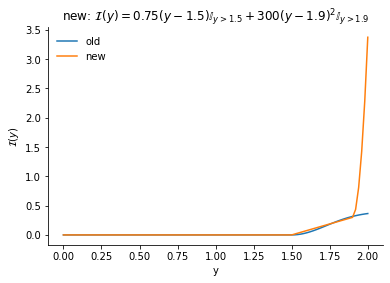

In [221]:
# plt.plot(y_grid_cap,3*intensity, label="x3")
# plt.plot(y_grid_cap,10*intensity, label="x10")
y_lower=1.5
intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
plt.plot(y_grid_cap, intensity, label="old")
y_lower=1.5
I = -1/2*r0*(np.exp((-r1)/4*(y_grid_cap- y_lower))-1)*(y_grid_cap >= y_lower)

# plt.plot(y_grid_cap, I, label="1.5")
y_lower=1.4
IO = -1/2*r0*(np.exp((-r1)/4*(y_grid_cap- y_lower))-1)*(y_grid_cap >= y_lower)
# plt.plot(y_grid_cap, IO, label="1.4")

func = 3/(y_bar - y_lower)**2*(y_grid_cap - y_lower)**2*(y_grid_cap >= y_lower)
# plt.plot(y_grid_cap, func, label="test 1.4")

func1 = 3/(y_bar - 1.5)**2*(y_grid_cap -1.5)**2*(y_grid_cap >= 1.5)
# plt.plot(y_grid_cap, func1, label="test 1.5")

func2 = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)
plt.plot(y_grid_cap, func2, label="new")

plt.title(r"new: $\mathcal{I}(y) = 0.75(y - 1.5)\mathbb{I}_{y>1.5} + 300(y - 1.9)^2\mathbb{I}_{y > 1.9}$")
plt.xlabel('y')
plt.ylabel(r"$\mathcal{I}(y)$")
plt.legend(frameon=False)
# plt.savefig('intensity.png',dpi=500, facecolor="w", edgecolor="w")

In [268]:
ϕ_average2 = np.average( np.exp(-1/ξp*ϕ_list2), weights=dmg_weight, axis=0)
ϕ_bound = -ξp*np.log(ϕ_average2)
ϕ_bound.shape

(201,)

In [460]:
numy_bar = len(pre_jump)-1
y_grid_cap = y_grid[:numy_bar+1]

y_lower = 1.5
# intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)

intensity = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)

dΛ = γ1 + γ2*y_grid_cap
ddΛ = γ2


ϕ = np.average(ϕ_list2, axis=0, weights=dmg_weight)[:numy_bar+1]
dy = hy
ems = η
ems_old = ems
episode = 0
lhs_error = 1
πᵈo = dmg_weight
πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)


tol= 1e-8
ϵ = 1
max_iter = 4000
while lhs_error > tol and episode < max_iter:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, "up")
    dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    # update control
    temp = dϕdy + (η-1)/δ*dΛ 
    weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πᶜ = πᶜo*np.exp(weight)
    πᶜ[πᶜ <= 1e-15] = 1e-15
    πᶜ = πᶜ/np.sum(πᶜ, axis=0)
    # update control
    a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
    b = (θ_list@πᶜ)*temp
    c = η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
    
    g_list = np.exp(1/ξp*(ϕ - ϕ_ref)) 
    weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape)
    By = (θ_list@πᶜ)*ems
    Cyy = ems**2*σy**2/2
    D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
    + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
    - 1/(2*ξw)*temp**2*ems**2*σy**2\
    + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
#     - intensity*ξp*(weighted  - np.exp(-1/ξp*ϕ))/np.exp(-1/ξp*ϕ)
    + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
    + intensity * (dmg_weight@(g_list*(ϕ_ref - ϕ)))
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (True, ϕ_bound[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems

    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

solution = dict(ϕ=ϕ, ems=ems, g_list=g_list)

episode: 1,	 ode error: 0.005266164739038355,	 ft error: 0.14492728690705922
episode: 2,	 ode error: 0.023478311673528422,	 ft error: 0.022198289388448228
episode: 3,	 ode error: 0.020000168408253104,	 ft error: 0.018682402773911894
episode: 4,	 ode error: 0.016935448356626644,	 ft error: 0.01567775813602998
episode: 5,	 ode error: 0.014095883437029394,	 ft error: 0.013022499108326785
episode: 6,	 ode error: 0.011520681150154581,	 ft error: 0.011476416770541065
episode: 7,	 ode error: 0.010073831792659003,	 ft error: 0.010716448957770686
episode: 8,	 ode error: 0.009062717954115947,	 ft error: 0.009877998735798976
episode: 9,	 ode error: 0.008664453318619775,	 ft error: 0.008951960047985874
episode: 10,	 ode error: 0.008134422974518468,	 ft error: 0.00847296670917319
episode: 11,	 ode error: 0.007517611231801377,	 ft error: 0.00808172849843447
episode: 12,	 ode error: 0.0070368229050225585,	 ft error: 0.0075989138160584835
episode: 13,	 ode error: 0.0067698554986007665,	 ft error: 0.00

episode: 149,	 ode error: 0.0009937051405435465,	 ft error: 0.0007072354265025282
episode: 150,	 ode error: 0.0009931717745525238,	 ft error: 0.0006988108769632184
episode: 151,	 ode error: 0.0009926524452643012,	 ft error: 0.0006904948016304147
episode: 152,	 ode error: 0.0009921484545015423,	 ft error: 0.0006822873771006321
episode: 153,	 ode error: 0.0009916610810672133,	 ft error: 0.0006741883889178624
episode: 154,	 ode error: 0.0009911915809318397,	 ft error: 0.000666197277669589
episode: 155,	 ode error: 0.000990741182124031,	 ft error: 0.0006583131806525699
episode: 156,	 ode error: 0.0009903110715918928,	 ft error: 0.000650534969506289
episode: 157,	 ode error: 0.0009899023909365756,	 ft error: 0.0006428612842084291
episode: 158,	 ode error: 0.0009895162307334282,	 ft error: 0.0006352905637223571
episode: 159,	 ode error: 0.0009891536173852154,	 ft error: 0.0006278210735244372
episode: 160,	 ode error: 0.0009888155040746506,	 ft error: 0.0006204509309091222
episode: 161,	 ode 

episode: 313,	 ode error: 0.0010050652404869423,	 ft error: 1.0406168238219493e-07
episode: 314,	 ode error: 0.0010050654146828639,	 ft error: 1.0275396089554079e-07
episode: 315,	 ode error: 0.0010050655724782864,	 ft error: 1.0139748773951851e-07
episode: 316,	 ode error: 0.0010050657136743135,	 ft error: 1.000942084772305e-07
episode: 317,	 ode error: 0.0010050658389101942,	 ft error: 9.880387485949882e-08
episode: 318,	 ode error: 0.0010050659521600655,	 ft error: 9.75025518101802e-08
episode: 319,	 ode error: 0.0010050660528746133,	 ft error: 9.627632513442563e-08
episode: 320,	 ode error: 0.0010050661396183679,	 ft error: 9.499217146213823e-08
episode: 321,	 ode error: 0.0010050662154616787,	 ft error: 9.381056287338652e-08
episode: 322,	 ode error: 0.0010050662817190047,	 ft error: 9.259327748978308e-08
episode: 323,	 ode error: 0.0010050663367712279,	 ft error: 9.140262058338067e-08
episode: 324,	 ode error: 0.0010050663811629265,	 ft error: 9.024932845491662e-08
episode: 325,	

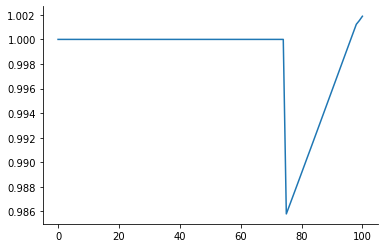

In [461]:
weighted, ϕ_new, g_list[:,-1]
plt.plot(weighted)

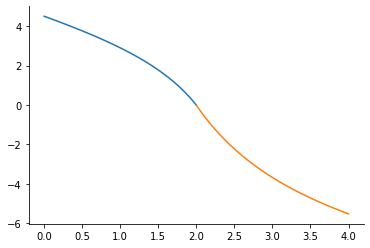

In [462]:
plt.plot(y_grid_cap, ϕ)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])
# plt.plot(ϕ_ref.T)
plt.show()

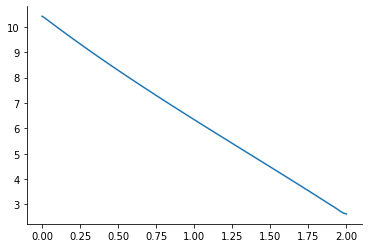

In [463]:
plt.plot(y_grid_cap,ems)
# plt.plot(y_grid_cap, ems_ref.T)
plt.show()

In [464]:
g_list[:,-1]

array([0.42676629, 0.53095817, 0.59745248, 0.65066559, 0.69421651,
       0.73202938, 0.76484396, 0.79519667, 0.82303195, 0.84881425,
       0.8728843 , 0.89550025, 0.91686277, 0.93713127, 0.9564347 ,
       0.974879  , 0.99255241, 1.00952937, 1.02587329, 1.0416388 ,
       1.05687327, 1.07161821, 1.08437136, 1.09818933, 1.11162031,
       1.12469005, 1.13742168, 1.14983604, 1.16195199, 1.17378665,
       1.18535564, 1.19667322, 1.20775247, 1.21860543, 1.22924316,
       1.23967591, 1.24991317, 1.26191725, 1.27179719, 1.28150496])

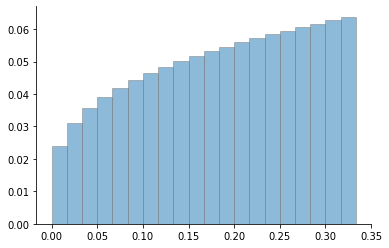

In [465]:
plt.hist(γ3_list, weights=g_list[:,-1]/np.sum(g_list[:,-1]), bins=20, ec="gray", alpha=0.5)
plt.show()

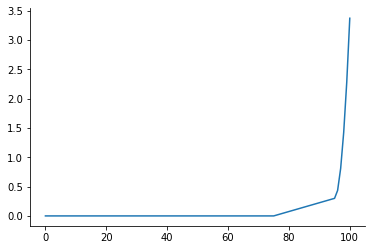

In [466]:
plt.plot(intensity)

In [467]:
numy_bar = len(pre_jump)-1
y_grid_cap = y_grid[:numy_bar+1]

y_lower = 1.5
# intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
intensity = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)

dΛ = γ1 + γ2*y_grid_cap
ddΛ = γ2


ϕ = np.average(ϕ_list2, axis=0, weights=dmg_weight)[:numy_bar+1]
dy = hy
ems = η
ems_old = ems
episode = 0
lhs_error = 1
πᵈo = dmg_weight
πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)


tol= 1e-8
ϵ = 1
max_iter = 4000
while lhs_error > tol and episode < max_iter:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, "up")
    dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    # update control
    temp = dϕdy + (η-1)/δ*dΛ 
    weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πᶜ = πᶜo*np.exp(weight)
    πᶜ[πᶜ <= 1e-15] = 1e-15
    πᶜ = πᶜ/np.sum(πᶜ, axis=0)
    # update control
    a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
    b = (θ_list@πᶜ)*temp
    c = η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
    
    g_list = np.exp(1/ξp*(ϕ - ϕ_ref)) 
    weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape) - intensity*(dmg_weight@g_list)
    By = (θ_list@πᶜ)*ems
    Cyy = ems**2*σy**2/2
    D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
    + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
    - 1/(2*ξw)*temp**2*ems**2*σy**2\
    + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
#     - intensity*ξp*(weighted  - np.exp(-1/ξp*ϕ))/np.exp(-1/ξp*ϕ)
    + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
    + intensity * (dmg_weight@(g_list*ϕ_ref))
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (True, ϕ_bound[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems

    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

solution2 = dict(ϕ=ϕ, ems=ems, g_list=g_list)

episode: 1,	 ode error: 0.004398686555056638,	 ft error: 0.22418998849828442
episode: 2,	 ode error: 0.012603741380982258,	 ft error: 0.17328180266914472
episode: 3,	 ode error: 0.024898809474634076,	 ft error: 0.14062154549198713
episode: 4,	 ode error: 0.03405098606226631,	 ft error: 0.11781855612507042
episode: 5,	 ode error: 0.03763197917326156,	 ft error: 0.10144290407396761
episode: 6,	 ode error: 0.039372772014582155,	 ft error: 0.08921777018654986
episode: 7,	 ode error: 0.04007081832566209,	 ft error: 0.07987048337339941
episode: 8,	 ode error: 0.04037665178054372,	 ft error: 0.0723621509089718
episode: 9,	 ode error: 0.04052597320955403,	 ft error: 0.06691524062819343
episode: 10,	 ode error: 0.04060411822710378,	 ft error: 0.06207957863611302
episode: 11,	 ode error: 0.04064711132967336,	 ft error: 0.05856435738802013
episode: 12,	 ode error: 0.040671268829717805,	 ft error: 0.0550489376208001
episode: 13,	 ode error: 0.04068518797769766,	 ft error: 0.052675290174815315
epis

episode: 147,	 ode error: 0.04223548771459799,	 ft error: 0.0057921884245812905
episode: 148,	 ode error: 0.04223544223531012,	 ft error: 0.0057228529604058664
episode: 149,	 ode error: 0.04223542502066689,	 ft error: 0.005654070727277638
episode: 150,	 ode error: 0.0422354359786479,	 ft error: 0.005586626844964471
episode: 151,	 ode error: 0.042235474476564006,	 ft error: 0.005520939038271777
episode: 152,	 ode error: 0.04223553940502713,	 ft error: 0.005455767066298023
episode: 153,	 ode error: 0.04223562928389474,	 ft error: 0.005391179139801583
episode: 154,	 ode error: 0.042235742405630966,	 ft error: 0.0053272315814223425
episode: 155,	 ode error: 0.042235877004622766,	 ft error: 0.005263970321060185
episode: 156,	 ode error: 0.042236031432951876,	 ft error: 0.005201432205928391
episode: 157,	 ode error: 0.042236204314979126,	 ft error: 0.005140403656109793
episode: 158,	 ode error: 0.042236394646481615,	 ft error: 0.005080272983194245
episode: 159,	 ode error: 0.0422366018011749

episode: 264,	 ode error: 0.04223803513525601,	 ft error: 1.2271740601477177e-06
episode: 265,	 ode error: 0.042238035046741194,	 ft error: 1.0848070175484281e-06
episode: 266,	 ode error: 0.0422380349683478,	 ft error: 9.589262255360609e-07
episode: 267,	 ode error: 0.04223803489897937,	 ft error: 8.47667921632933e-07
episode: 268,	 ode error: 0.04223803483765073,	 ft error: 7.493721483342597e-07
episode: 269,	 ode error: 0.04223803478346804,	 ft error: 6.625613062638536e-07
episode: 270,	 ode error: 0.042238034735628247,	 ft error: 5.859208576097785e-07
episode: 271,	 ode error: 0.04223803469341365,	 ft error: 5.182819773352776e-07
episode: 272,	 ode error: 0.042238034656173866,	 ft error: 4.586059700883993e-07
episode: 273,	 ode error: 0.04223803462333267,	 ft error: 4.059702956027422e-07
episode: 274,	 ode error: 0.04223803459436823,	 ft error: 3.5955602850634705e-07
episode: 275,	 ode error: 0.04223803456881879,	 ft error: 3.186366130947249e-07
episode: 276,	 ode error: 0.04223803

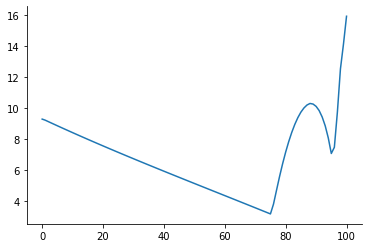

In [439]:
plt.plot(ems)

In [447]:
numy_bar = len(pre_jump)-1
y_grid_cap = y_grid[:numy_bar+1]

y_lower = 1.5
# intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
intensity = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)

dΛ = γ1 + γ2*y_grid_cap
ddΛ = γ2


ϕ = np.average(ϕ_list2, axis=0, weights=dmg_weight)[:numy_bar+1]
dy = hy
ems = η
ems_old = ems
episode = 0
lhs_error = 1
πᵈo = dmg_weight
πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)


tol= 1e-8
ϵ = 1
max_iter = 4000
while lhs_error > tol and episode < max_iter:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, "up")
    dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    # update control
    temp = dϕdy + (η-1)/δ*dΛ 
    weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πᶜ = πᶜo*np.exp(weight)
    πᶜ[πᶜ <= 1e-15] = 1e-15
    πᶜ = πᶜ/np.sum(πᶜ, axis=0)
    # update control
    a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
    b = (θ_list@πᶜ)*temp
    c = η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
    
    g_list = np.exp(1/ξp*(ϕ - ϕ_ref)) 
    weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape) - intensity*(dmg_weight@g_list)
    By = (θ_list@πᶜ)*ems
    Cyy = ems**2*σy**2/2
    D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
    + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
    - 1/(2*ξw)*temp**2*ems**2*σy**2\
    + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
#     - intensity*ξp*(weighted  - np.exp(-1/ξp*ϕ))/np.exp(-1/ξp*ϕ)
    + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
    + intensity * (dmg_weight@(g_list*ϕ_ref))
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (False, ϕ_bound[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems

    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

solution3 = dict(ϕ=ϕ, ems=ems, g_list=g_list)

episode: 1,	 ode error: 0.004398640522202256,	 ft error: 0.2241942238710487
episode: 2,	 ode error: 0.029084971911965695,	 ft error: 0.1732890819254972
episode: 3,	 ode error: 0.045098620156840845,	 ft error: 0.14060984016954148
episode: 4,	 ode error: 0.052702136109169705,	 ft error: 0.11779388370982924
episode: 5,	 ode error: 0.054485534497459236,	 ft error: 0.10144800060755665
episode: 6,	 ode error: 0.0544727551100056,	 ft error: 0.08921942216160816
episode: 7,	 ode error: 0.054486026686257134,	 ft error: 0.0798740069114594
episode: 8,	 ode error: 0.05426475862450723,	 ft error: 0.07236600131390625
episode: 9,	 ode error: 0.05405190835208515,	 ft error: 0.06692056065919749
episode: 10,	 ode error: 0.05393559859037757,	 ft error: 0.06208104056215835
episode: 11,	 ode error: 0.053878785310730974,	 ft error: 0.05856600223801123
episode: 12,	 ode error: 0.05385005421177499,	 ft error: 0.05505069324092837
episode: 13,	 ode error: 0.05383431746033383,	 ft error: 0.052676348483996493
epis

episode: 122,	 ode error: 0.053811000954536406,	 ft error: 0.007869479230346865
episode: 123,	 ode error: 0.05381100214843722,	 ft error: 0.007771019542876623
episode: 124,	 ode error: 0.05381100310153051,	 ft error: 0.007672365537243042
episode: 125,	 ode error: 0.05381100377806791,	 ft error: 0.007579710295838371
episode: 126,	 ode error: 0.05381100413958027,	 ft error: 0.007484910252884447
episode: 127,	 ode error: 0.05381100413545868,	 ft error: 0.007391335895293949
episode: 128,	 ode error: 0.05381100370551399,	 ft error: 0.007302075512967576
episode: 129,	 ode error: 0.053811002781634934,	 ft error: 0.007211319897048707
episode: 130,	 ode error: 0.053811001288502615,	 ft error: 0.0071215627586656005
episode: 131,	 ode error: 0.05381099914500253,	 ft error: 0.007036042858851399
episode: 132,	 ode error: 0.05381099626799358,	 ft error: 0.006949497421079975
episode: 133,	 ode error: 0.053810992577051395,	 ft error: 0.006862521653144604
episode: 134,	 ode error: 0.05381098800207328,	

episode: 274,	 ode error: 0.053810964949579126,	 ft error: 3.975682023593663e-07
episode: 275,	 ode error: 0.05381096495060903,	 ft error: 3.544589786130814e-07
episode: 276,	 ode error: 0.05381096494728349,	 ft error: 3.1621517138091804e-07
episode: 277,	 ode error: 0.05381096494537138,	 ft error: 2.82274868368404e-07
episode: 278,	 ode error: 0.05381096494417562,	 ft error: 2.521409747657799e-07
episode: 279,	 ode error: 0.05381096494475386,	 ft error: 2.25373822715369e-07
episode: 280,	 ode error: 0.053810964941403944,	 ft error: 2.0158495228628226e-07
episode: 281,	 ode error: 0.05381096494367042,	 ft error: 1.8043090665997852e-07
episode: 282,	 ode error: 0.05381096493954042,	 ft error: 1.6160860738523297e-07
episode: 283,	 ode error: 0.053810964944008464,	 ft error: 1.448501052436768e-07
episode: 284,	 ode error: 0.05381096493878147,	 ft error: 1.299192078363376e-07
episode: 285,	 ode error: 0.05381096494024916,	 ft error: 1.1660721987993838e-07
episode: 286,	 ode error: 0.053810

In [448]:
numy_bar = len(pre_jump)-1
y_grid_cap = y_grid[:numy_bar+1]

y_lower = 1.5
# intensity = r0*(np.exp(r1/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
intensity = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)

dΛ = γ1 + γ2*y_grid_cap
ddΛ = γ2


ϕ = np.average(ϕ_list2, axis=0, weights=dmg_weight)[:numy_bar+1]
dy = hy
ems = η
ems_old = ems
episode = 0
lhs_error = 1
πᵈo = dmg_weight
πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)


tol= 1e-8
ϵ = 1
max_iter = 4000
while lhs_error > tol and episode < max_iter:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, "up")
    dϕdyy = derivative_1d(ϕ, 2, dy, "up")
    # update control
    temp = dϕdy + (η-1)/δ*dΛ 
    weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πᶜ = πᶜo*np.exp(weight)
    πᶜ[πᶜ <= 1e-15] = 1e-15
    πᶜ = πᶜ/np.sum(πᶜ, axis=0)
    # update control
    a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
    b = (θ_list@πᶜ)*temp
    c = η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
    
    g_list = np.exp(1/ξp*(ϕ - ϕ_ref)) 
    weighted = np.average(np.exp(-1/ξp*ϕ_ref), axis=0, weights=dmg_weight)
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape)
    By = (θ_list@πᶜ)*ems
    Cyy = ems**2*σy**2/2
    D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
    + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
    - 1/(2*ξw)*temp**2*ems**2*σy**2\
    + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
#     - intensity*ξp*(weighted  - np.exp(-1/ξp*ϕ))/np.exp(-1/ξp*ϕ)
    + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
    + intensity * (dmg_weight@(g_list*(ϕ_ref - ϕ) ))
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (False, ϕ_bound[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems

    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

solution4 = dict(ϕ=ϕ, ems=ems, g_list=g_list)

episode: 1,	 ode error: 0.005361174201479942,	 ft error: 0.0055156509051871305
episode: 2,	 ode error: 0.0019469968841598108,	 ft error: 0.0023140421942292044
episode: 3,	 ode error: 0.0013938048621070856,	 ft error: 0.0018511845896934664
episode: 4,	 ode error: 0.001271615944348714,	 ft error: 0.0016850889342295838
episode: 5,	 ode error: 0.0012111664497298953,	 ft error: 0.0016367664668148207
episode: 6,	 ode error: 0.0011765168964633678,	 ft error: 0.0015771591955447972
episode: 7,	 ode error: 0.001144648815238472,	 ft error: 0.001509364706202776
episode: 8,	 ode error: 0.0011126759635574912,	 ft error: 0.0015345742916864635
episode: 9,	 ode error: 0.0010894762311957282,	 ft error: 0.0014976237864187114
episode: 10,	 ode error: 0.0012829416033420526,	 ft error: 0.0015759683340442199
episode: 11,	 ode error: 0.0015221239370592533,	 ft error: 0.0017105467222554016
episode: 12,	 ode error: 0.0017566043432479285,	 ft error: 0.0019456704656967139
episode: 13,	 ode error: 0.00198761217980

episode: 193,	 ode error: 0.0121426921198355,	 ft error: 0.012226914605096617
episode: 194,	 ode error: 0.012100629229135532,	 ft error: 0.012130783116615085
episode: 195,	 ode error: 0.012057350615940432,	 ft error: 0.012084716851322508
episode: 196,	 ode error: 0.012013039025533592,	 ft error: 0.012094135035079834
episode: 197,	 ode error: 0.011969096104918635,	 ft error: 0.012050904391152972
episode: 198,	 ode error: 0.011925553071640824,	 ft error: 0.011942656872576674
episode: 199,	 ode error: 0.011880548649558405,	 ft error: 0.011893942503538035
episode: 200,	 ode error: 0.011834319770684353,	 ft error: 0.011922506296507152
episode: 201,	 ode error: 0.011789013571528728,	 ft error: 0.011880720537838396
episode: 202,	 ode error: 0.011744498365901974,	 ft error: 0.011743327549190496
episode: 203,	 ode error: 0.011697818525022774,	 ft error: 0.01169111210434215
episode: 204,	 ode error: 0.011650712084441558,	 ft error: 0.011636732546310036
episode: 205,	 ode error: 0.011602340856979

episode: 388,	 ode error: 0.0034707612690695264,	 ft error: 0.003515534851624036
episode: 389,	 ode error: 0.0034414943724756647,	 ft error: 0.003499943843285447
episode: 390,	 ode error: 0.003413095960249947,	 ft error: 0.003426499008490236
episode: 391,	 ode error: 0.003385180565298712,	 ft error: 0.003397893095654414
episode: 392,	 ode error: 0.0033573524173486358,	 ft error: 0.003369021742246847
episode: 393,	 ode error: 0.003329685088661778,	 ft error: 0.003341083102740061
episode: 394,	 ode error: 0.0033022095338087684,	 ft error: 0.003311524525976939
episode: 395,	 ode error: 0.003275158162100049,	 ft error: 0.0032574737085777627
episode: 396,	 ode error: 0.0032475433492652125,	 ft error: 0.0032877656616454587
episode: 397,	 ode error: 0.0032199821941910484,	 ft error: 0.0032759415762404487
episode: 398,	 ode error: 0.0031930074674954984,	 ft error: 0.0032092428202981083
episode: 399,	 ode error: 0.0031665411600691265,	 ft error: 0.003181306186766708
episode: 400,	 ode error: 0.

episode: 574,	 ode error: 0.0006590950952032326,	 ft error: 0.0006536101308425302
episode: 575,	 ode error: 0.0006536812849249757,	 ft error: 0.0006840697024079745
episode: 576,	 ode error: 0.000659587094715211,	 ft error: 0.000672398753180925
episode: 577,	 ode error: 0.0007329013023155695,	 ft error: 0.0006593660506117871
episode: 578,	 ode error: 0.0006404667367261307,	 ft error: 0.0006344073096595793
episode: 579,	 ode error: 0.0006329423741001372,	 ft error: 0.0006259249455800031
episode: 580,	 ode error: 0.000627153476842543,	 ft error: 0.0006532727314856324
episode: 581,	 ode error: 0.0006321541333118158,	 ft error: 0.0006551082060832769
episode: 582,	 ode error: 0.0006285925246512503,	 ft error: 0.0006238851334856577
episode: 583,	 ode error: 0.0006151342372385515,	 ft error: 0.0006128338952464674
episode: 584,	 ode error: 0.000608039209178915,	 ft error: 0.000597320783505495
episode: 585,	 ode error: 0.0006031196650592985,	 ft error: 0.0005910075584765195
episode: 586,	 ode er

episode: 734,	 ode error: 0.0002598723067254449,	 ft error: 0.00018724375579015629
episode: 735,	 ode error: 0.00017023977679704594,	 ft error: 0.00016526098686497903
episode: 736,	 ode error: 0.00016805330504290894,	 ft error: 0.00016562378761975083
episode: 737,	 ode error: 0.00025083125197192246,	 ft error: 0.00015777739353195486
episode: 738,	 ode error: 0.00025788869237830525,	 ft error: 0.00018313173065998
episode: 739,	 ode error: 0.00016693909306847443,	 ft error: 0.00016153841051735895
episode: 740,	 ode error: 0.0001648342604349956,	 ft error: 0.00016071397044203906
episode: 741,	 ode error: 0.0002534908483140391,	 ft error: 0.0001531458867134461
episode: 742,	 ode error: 0.00026141163168530435,	 ft error: 0.00017986953072757217
episode: 743,	 ode error: 0.0001632961961598317,	 ft error: 0.00015790273705196256
episode: 744,	 ode error: 0.00016132410450912793,	 ft error: 0.00015647422437670144
episode: 745,	 ode error: 0.0002576840891233556,	 ft error: 0.00014928469331421113
e

episode: 884,	 ode error: 0.0001492912417121045,	 ft error: 3.843963164040787e-05
episode: 885,	 ode error: 0.00017198056861585098,	 ft error: 3.964048076721127e-05
episode: 886,	 ode error: 0.00019500223099350178,	 ft error: 7.587580209733602e-05
episode: 887,	 ode error: 6.090132676336846e-05,	 ft error: 5.747196628114182e-05
episode: 888,	 ode error: 5.904291838122744e-05,	 ft error: 5.0414345272642436e-05
episode: 889,	 ode error: 0.00011692662896850559,	 ft error: 3.665492034077289e-05
episode: 890,	 ode error: 0.00015053577493251424,	 ft error: 3.507570062666332e-05
episode: 891,	 ode error: 0.00018038316193842718,	 ft error: 7.360666457145726e-05
episode: 892,	 ode error: 6.02983900516163e-05,	 ft error: 5.429339256490806e-05
episode: 893,	 ode error: 5.794174199121038e-05,	 ft error: 3.8821406508127154e-05
episode: 894,	 ode error: 7.40102216519739e-05,	 ft error: 4.754911656501548e-05
episode: 895,	 ode error: 0.00017481124397226988,	 ft error: 3.338283277809495e-05
episode: 8

episode: 1061,	 ode error: 0.0001245071064154002,	 ft error: 5.7067349302108994e-05
episode: 1062,	 ode error: 6.9425060020889e-05,	 ft error: 3.2333957971530936e-05
episode: 1063,	 ode error: 3.9652255254749025e-05,	 ft error: 2.3760841584952175e-05
episode: 1064,	 ode error: 3.694923335754996e-05,	 ft error: 6.461332160512256e-05
episode: 1065,	 ode error: 5.955282012098939e-05,	 ft error: 6.971520441734214e-05
episode: 1066,	 ode error: 7.632248829450572e-05,	 ft error: 3.7920587635298375e-05
episode: 1067,	 ode error: 3.87009780673242e-05,	 ft error: 2.7567894865576648e-05
episode: 1068,	 ode error: 3.697455724556431e-05,	 ft error: 3.699009508917328e-05
episode: 1069,	 ode error: 3.432792731780654e-05,	 ft error: 2.7126623474593714e-05
episode: 1070,	 ode error: 3.4735356327669775e-05,	 ft error: 3.6537818705717484e-05
episode: 1071,	 ode error: 6.325692239200764e-05,	 ft error: 1.1500733941183228e-05
episode: 1072,	 ode error: 6.15574767272864e-05,	 ft error: 7.177630972243776e-0

episode: 1236,	 ode error: 4.558984268736299e-05,	 ft error: 4.642160606316281e-05
episode: 1237,	 ode error: 4.512051607365175e-05,	 ft error: 6.479836045070186e-05
episode: 1238,	 ode error: 0.00013506471200522285,	 ft error: 2.3459989188623354e-05
episode: 1239,	 ode error: 0.00014477523184885932,	 ft error: 7.114419932729987e-05
episode: 1240,	 ode error: 4.6964533163176836e-05,	 ft error: 4.511562340336894e-05
episode: 1241,	 ode error: 4.6305681938113574e-05,	 ft error: 5.758598590954733e-05
episode: 1242,	 ode error: 0.00012747602723796325,	 ft error: 1.9863501443673215e-05
episode: 1243,	 ode error: 0.00013614327378609625,	 ft error: 6.765024976917999e-05
episode: 1244,	 ode error: 4.745205718413581e-05,	 ft error: 4.361854037693291e-05
episode: 1245,	 ode error: 4.651401998113924e-05,	 ft error: 5.5551078893323336e-05
episode: 1246,	 ode error: 0.00012542709294305343,	 ft error: 1.9048582561076444e-05
episode: 1247,	 ode error: 0.0001340503093681944,	 ft error: 6.5547993888692

episode: 1428,	 ode error: 0.00013444746840195199,	 ft error: 2.498977091036636e-05
episode: 1429,	 ode error: 0.0001457038192976129,	 ft error: 6.371808605543094e-05
episode: 1430,	 ode error: 4.4629651373709334e-05,	 ft error: 3.999849506897135e-05
episode: 1431,	 ode error: 4.384801105247749e-05,	 ft error: 6.164734592761789e-05
episode: 1432,	 ode error: 0.00013850765296938294,	 ft error: 2.6634789782598034e-05
episode: 1433,	 ode error: 0.00015090598007534706,	 ft error: 6.373667389336646e-05
episode: 1434,	 ode error: 4.4325821082269456e-05,	 ft error: 3.976551752860047e-05
episode: 1435,	 ode error: 4.3640318572221726e-05,	 ft error: 6.33623551129503e-05
episode: 1436,	 ode error: 0.00014372698443589071,	 ft error: 2.8561045228414628e-05
episode: 1437,	 ode error: 0.00015745622870563802,	 ft error: 6.416728715485931e-05
episode: 1438,	 ode error: 4.407012397854293e-05,	 ft error: 3.976879652523024e-05
episode: 1439,	 ode error: 4.351569232706465e-05,	 ft error: 6.530585096342634

episode: 1623,	 ode error: 3.142284603675771e-05,	 ft error: 8.48191225095718e-05
episode: 1624,	 ode error: 7.458802312981794e-05,	 ft error: 3.455040996325209e-05
episode: 1625,	 ode error: 3.835960852413556e-05,	 ft error: 2.2763358030530867e-05
episode: 1626,	 ode error: 2.715708568329367e-05,	 ft error: 4.9418263741607404e-05
episode: 1627,	 ode error: 0.00016595055613342902,	 ft error: 4.830700910662955e-05
episode: 1628,	 ode error: 4.6654573625376505e-05,	 ft error: 2.3423443911596564e-05
episode: 1629,	 ode error: 3.0199116221277245e-05,	 ft error: 8.46124811602067e-05
episode: 1630,	 ode error: 7.188613772547703e-05,	 ft error: 3.514105236313014e-05
episode: 1631,	 ode error: 3.7210705598311744e-05,	 ft error: 2.2576271046403917e-05
episode: 1632,	 ode error: 2.7859764187634917e-05,	 ft error: 7.333817145660504e-05
episode: 1633,	 ode error: 0.00014962155113160125,	 ft error: 4.9828616450753316e-05
episode: 1634,	 ode error: 4.4240821256605334e-05,	 ft error: 8.09587345642626

episode: 1815,	 ode error: 5.8871416165798274e-05,	 ft error: 3.4337883653812185e-05
episode: 1816,	 ode error: 5.5481165256679454e-05,	 ft error: 2.675769198301481e-05
episode: 1817,	 ode error: 3.434346369508845e-05,	 ft error: 2.1477461178420754e-05
episode: 1818,	 ode error: 3.279275763370948e-05,	 ft error: 2.020091752719111e-05
episode: 1819,	 ode error: 3.144060344806299e-05,	 ft error: 2.1092401248701265e-05
episode: 1820,	 ode error: 3.676679052529164e-05,	 ft error: 2.7507762299983085e-05
episode: 1821,	 ode error: 4.677043908210554e-05,	 ft error: 5.6361427207107795e-05
episode: 1822,	 ode error: 7.277545028806787e-05,	 ft error: 2.9221850491367718e-05
episode: 1823,	 ode error: 3.498431513393463e-05,	 ft error: 2.0904417519673757e-05
episode: 1824,	 ode error: 3.290696886902589e-05,	 ft error: 1.924648756990166e-05
episode: 1825,	 ode error: 3.130540724990971e-05,	 ft error: 1.874451883487893e-05
episode: 1826,	 ode error: 3.091786496264848e-05,	 ft error: 8.581741838842305

episode: 2006,	 ode error: 0.00019524851459094827,	 ft error: 4.7500433680625065e-05
episode: 2007,	 ode error: 7.720460698290577e-05,	 ft error: 2.9225661038800865e-05
episode: 2008,	 ode error: 7.361629605746878e-05,	 ft error: 2.7734983429006377e-05
episode: 2009,	 ode error: 7.248735065078227e-05,	 ft error: 2.9454991205213332e-05
episode: 2010,	 ode error: 7.335583651052469e-05,	 ft error: 3.247200205436229e-05
episode: 2011,	 ode error: 7.527644819206591e-05,	 ft error: 3.552983188637171e-05
episode: 2012,	 ode error: 7.757618184962844e-05,	 ft error: 3.8936599947803074e-05
episode: 2013,	 ode error: 8.013588584966647e-05,	 ft error: 4.312253224725282e-05
episode: 2014,	 ode error: 8.30827017336555e-05,	 ft error: 4.8140178446232085e-05
episode: 2015,	 ode error: 8.657713394052968e-05,	 ft error: 5.4223640364448045e-05
episode: 2016,	 ode error: 9.080734719352224e-05,	 ft error: 6.194453088692597e-05
episode: 2017,	 ode error: 0.00011094454454811664,	 ft error: 5.321069888974961e

episode: 2196,	 ode error: 4.4401662799356534e-05,	 ft error: 7.158893051784077e-05
episode: 2197,	 ode error: 6.812260585999097e-05,	 ft error: 4.3233687245347596e-05
episode: 2198,	 ode error: 3.951693332222839e-05,	 ft error: 3.176265731319461e-05
episode: 2199,	 ode error: 3.6835883697877714e-05,	 ft error: 2.5933071915673622e-05
episode: 2200,	 ode error: 3.615896950270869e-05,	 ft error: 2.292598870834439e-05
episode: 2201,	 ode error: 3.680093020651254e-05,	 ft error: 8.479004133743473e-05
episode: 2202,	 ode error: 5.38758657669669e-05,	 ft error: 7.0710235569038105e-06
episode: 2203,	 ode error: 4.306033149267807e-05,	 ft error: 1.3700388877602165e-05
episode: 2204,	 ode error: 4.131917153706033e-05,	 ft error: 2.8951385784736772e-05
episode: 2205,	 ode error: 3.808871500152189e-05,	 ft error: 2.5442049357948804e-05
episode: 2206,	 ode error: 3.670272015811327e-05,	 ft error: 1.9445695471631552e-05
episode: 2207,	 ode error: 3.857653626894442e-05,	 ft error: 5.392562987527327e

episode: 2387,	 ode error: 0.00011100982031965467,	 ft error: 2.7604798888525295e-05
episode: 2388,	 ode error: 0.00011753405384051785,	 ft error: 5.370019477535237e-05
episode: 2389,	 ode error: 3.606421552011796e-05,	 ft error: 3.204583518989779e-05
episode: 2390,	 ode error: 3.526337533359125e-05,	 ft error: 6.232321612387182e-05
episode: 2391,	 ode error: 0.0001162480155020712,	 ft error: 2.708173212706555e-05
episode: 2392,	 ode error: 0.000123218023598326,	 ft error: 5.3980629047600814e-05
episode: 2393,	 ode error: 3.744805382427385e-05,	 ft error: 3.2603232528849446e-05
episode: 2394,	 ode error: 3.658342878846976e-05,	 ft error: 6.300408474224639e-05
episode: 2395,	 ode error: 0.00012437467283218928,	 ft error: 2.843450466194497e-05
episode: 2396,	 ode error: 0.0001328401293126391,	 ft error: 5.512351429448614e-05
episode: 2397,	 ode error: 3.82745577631044e-05,	 ft error: 3.337590838814464e-05
episode: 2398,	 ode error: 3.7507757352603366e-05,	 ft error: 6.462806187013115e-05

episode: 2576,	 ode error: 4.146604040487778e-05,	 ft error: 3.679714991466909e-05
episode: 2577,	 ode error: 4.078577338521849e-05,	 ft error: 6.467401539822504e-05
episode: 2578,	 ode error: 0.00014360312484153204,	 ft error: 3.045174990745636e-05
episode: 2579,	 ode error: 0.00015649187603042347,	 ft error: 6.101868298635793e-05
episode: 2580,	 ode error: 4.172965537320439e-05,	 ft error: 3.748912934398163e-05
episode: 2581,	 ode error: 4.043003410206247e-05,	 ft error: 3.389100458939254e-05
episode: 2582,	 ode error: 4.056807806443463e-05,	 ft error: 4.775809346480031e-05
episode: 2583,	 ode error: 5.4514109226702634e-05,	 ft error: 3.122296455693174e-05
episode: 2584,	 ode error: 0.00012114529986448352,	 ft error: 5.3182387725669855e-05
episode: 2585,	 ode error: 4.27256639307233e-05,	 ft error: 3.537508840167902e-05
episode: 2586,	 ode error: 4.061924175191578e-05,	 ft error: 3.278426823882796e-05
episode: 2587,	 ode error: 4.007578686811286e-05,	 ft error: 4.455819385640325e-05


episode: 2767,	 ode error: 9.261480115964338e-05,	 ft error: 5.232481507366771e-05
episode: 2768,	 ode error: 0.00012099987438407567,	 ft error: 5.718619606742692e-05
episode: 2769,	 ode error: 4.0045959560239264e-05,	 ft error: 3.0393347433488316e-05
episode: 2770,	 ode error: 2.9452957349990205e-05,	 ft error: 6.419321409900647e-05
episode: 2771,	 ode error: 8.556644399171365e-05,	 ft error: 2.6722103866561042e-05
episode: 2772,	 ode error: 9.191261644830861e-05,	 ft error: 4.304663853993418e-05
episode: 2773,	 ode error: 0.0001234768835608746,	 ft error: 5.964954788417742e-05
episode: 2774,	 ode error: 3.4702261740016116e-05,	 ft error: 3.353587021504012e-05
episode: 2775,	 ode error: 3.38640711533833e-05,	 ft error: 6.170265569327427e-05
episode: 2776,	 ode error: 9.701245303363193e-05,	 ft error: 2.437993992021603e-05
episode: 2777,	 ode error: 0.00010396933011970477,	 ft error: 4.467219653125909e-05
episode: 2778,	 ode error: 0.0001426965779357664,	 ft error: 6.445582124658955e-0

episode: 2957,	 ode error: 0.00011918865166934967,	 ft error: 3.900812560075906e-05
episode: 2958,	 ode error: 4.349552531068834e-05,	 ft error: 2.953015734252773e-05
episode: 2959,	 ode error: 3.132867035349207e-05,	 ft error: 8.255800324619145e-05
episode: 2960,	 ode error: 6.825664055491731e-05,	 ft error: 3.076402763646513e-05
episode: 2961,	 ode error: 3.690908950701455e-05,	 ft error: 2.2893258527112437e-05
episode: 2962,	 ode error: 3.2947508276218174e-05,	 ft error: 7.237598503984088e-05
episode: 2963,	 ode error: 0.00014971101003749543,	 ft error: 0.00011772442761426305
episode: 2964,	 ode error: 0.00013811113473069514,	 ft error: 5.201864429515979e-05
episode: 2965,	 ode error: 4.84226349868333e-05,	 ft error: 1.7782362691676212e-05
episode: 2966,	 ode error: 3.441478304647139e-05,	 ft error: 1.2053834208991532e-05
episode: 2967,	 ode error: 3.4666593591539674e-05,	 ft error: 5.53814979831202e-05
episode: 2968,	 ode error: 5.11252262499623e-05,	 ft error: 3.455283280917598e-0

episode: 3152,	 ode error: 6.285041669519542e-05,	 ft error: 7.299549019545992e-05
episode: 3153,	 ode error: 7.956744970227803e-05,	 ft error: 3.499882011492872e-05
episode: 3154,	 ode error: 3.924376837838306e-05,	 ft error: 2.1431750707456843e-05
episode: 3155,	 ode error: 2.9552773926327935e-05,	 ft error: 2.0520611657026677e-05
episode: 3156,	 ode error: 2.890952429536464e-05,	 ft error: 1.9205939069344424e-05
episode: 3157,	 ode error: 2.833037980864983e-05,	 ft error: 3.229445793451191e-05
episode: 3158,	 ode error: 3.9374527777150115e-05,	 ft error: 1.6762249504864712e-05
episode: 3159,	 ode error: 3.918687834195134e-05,	 ft error: 4.601949926907878e-05
episode: 3160,	 ode error: 5.1585126901981804e-05,	 ft error: 7.42880356634501e-05
episode: 3161,	 ode error: 8.25815017721776e-05,	 ft error: 0.00010099686242526218
episode: 3162,	 ode error: 0.00013486850568110442,	 ft error: 2.851028276129597e-05
episode: 3163,	 ode error: 3.6719122860226494e-05,	 ft error: 9.38348889611973e-

episode: 3343,	 ode error: 3.7882881054412954e-05,	 ft error: 2.1146174355557434e-05
episode: 3344,	 ode error: 2.926105431336201e-05,	 ft error: 1.754187851066291e-05
episode: 3345,	 ode error: 2.8625774421794925e-05,	 ft error: 8.98152308073108e-05
episode: 3346,	 ode error: 6.129285648276417e-05,	 ft error: 7.953302388230554e-06
episode: 3347,	 ode error: 4.0193898286258745e-05,	 ft error: 2.708400307227521e-05
episode: 3348,	 ode error: 3.249197222580935e-05,	 ft error: 1.9155571846951602e-05
episode: 3349,	 ode error: 4.159370510251059e-05,	 ft error: 2.3033365529556704e-05
episode: 3350,	 ode error: 2.9974313607558645e-05,	 ft error: 1.8534261569946864e-05
episode: 3351,	 ode error: 2.826423975732517e-05,	 ft error: 2.0571448247075352e-05
episode: 3352,	 ode error: 3.650034990060336e-05,	 ft error: 2.129150312679684e-05
episode: 3353,	 ode error: 4.270621706459199e-05,	 ft error: 6.875853585608382e-05
episode: 3354,	 ode error: 6.444357974257076e-05,	 ft error: 8.014151771718048e

episode: 3533,	 ode error: 4.3731618623046864e-05,	 ft error: 6.53236091832099e-05
episode: 3534,	 ode error: 0.0001502078333892598,	 ft error: 3.045285587965907e-05
episode: 3535,	 ode error: 0.0001649740762357521,	 ft error: 6.491916761852679e-05
episode: 3536,	 ode error: 4.400054073595838e-05,	 ft error: 4.00020324784478e-05
episode: 3537,	 ode error: 4.27172513773888e-05,	 ft error: 3.616443011100756e-05
episode: 3538,	 ode error: 4.2808808218705585e-05,	 ft error: 4.7262261472447165e-05
episode: 3539,	 ode error: 6.024463891331211e-05,	 ft error: 2.6677160128940614e-05
episode: 3540,	 ode error: 0.0001204751381128355,	 ft error: 5.470522085637697e-05
episode: 3541,	 ode error: 4.419663456330103e-05,	 ft error: 3.6843241105088964e-05
episode: 3542,	 ode error: 4.2051371997142706e-05,	 ft error: 3.409209813476366e-05
episode: 3543,	 ode error: 4.068636289797367e-05,	 ft error: 6.262584993965703e-05
episode: 3544,	 ode error: 0.0001850934971166368,	 ft error: 6.352691905142649e-05
e

episode: 3727,	 ode error: 7.998258354934007e-05,	 ft error: 4.080786976512485e-05
episode: 3728,	 ode error: 8.224219816233003e-05,	 ft error: 4.4981765371154836e-05
episode: 3729,	 ode error: 8.512147528327851e-05,	 ft error: 4.9973362330923976e-05
episode: 3730,	 ode error: 8.863068457500012e-05,	 ft error: 5.596987113598573e-05
episode: 3731,	 ode error: 0.0001007558049562346,	 ft error: 6.333074697639773e-05
episode: 3732,	 ode error: 0.00012602790194843339,	 ft error: 6.19041958032085e-05
episode: 3733,	 ode error: 4.634389894840607e-05,	 ft error: 3.1214249902156155e-05
episode: 3734,	 ode error: 2.725450276996888e-05,	 ft error: 7.139932208577449e-05
episode: 3735,	 ode error: 8.38605121260827e-05,	 ft error: 2.9099955906275454e-05
episode: 3736,	 ode error: 8.757767185274545e-05,	 ft error: 4.2552688947594675e-05
episode: 3737,	 ode error: 0.00011383695994855725,	 ft error: 5.384877470060445e-05
episode: 3738,	 ode error: 0.00014566484399775037,	 ft error: 6.90201621154074e-05

episode: 3915,	 ode error: 4.302046866853926e-05,	 ft error: 3.559747510628597e-05
episode: 3916,	 ode error: 4.086964161006956e-05,	 ft error: 3.294751544569152e-05
episode: 3917,	 ode error: 3.9583373991763926e-05,	 ft error: 5.8162545364837115e-05
episode: 3918,	 ode error: 0.0001773929485468645,	 ft error: 6.13832484432919e-05
episode: 3919,	 ode error: 4.135716912312404e-05,	 ft error: 2.6553352979519218e-05
episode: 3920,	 ode error: 3.916967324750498e-05,	 ft error: 7.694044309314307e-05
episode: 3921,	 ode error: 6.154086723429708e-05,	 ft error: 3.951789048706189e-05
episode: 3922,	 ode error: 3.894849239587106e-05,	 ft error: 2.727138219960068e-05
episode: 3923,	 ode error: 3.7341439959481804e-05,	 ft error: 2.5681722551240682e-05
episode: 3924,	 ode error: 3.595892386784594e-05,	 ft error: 2.3483460491746655e-05
episode: 3925,	 ode error: 3.4873266841609074e-05,	 ft error: 2.010291993670421e-05
episode: 3926,	 ode error: 3.654195634565649e-05,	 ft error: 2.5695139548531643e-

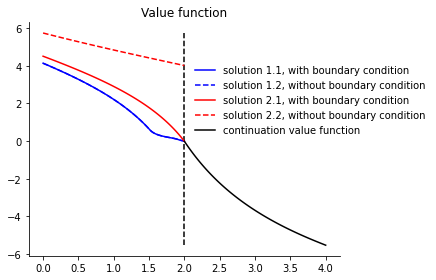

In [628]:
plt.plot(y_grid_cap, solution2['φ'], label="solution 1.1, with boundary condition", color="blue")
plt.plot(y_grid_cap, solution3['φ'], label="solution 1.2, without boundary condition", 
         color="blue", linestyle="dashed",
        )

plt.plot(y_grid_cap, solution['φ'], label="solution 2.1, with boundary condition", color="red")
plt.plot(y_grid_cap, solution4['φ'], label="solution 2.2, without boundary condition", color="red", 
        linestyle="dashed")
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="continuation value function", color="black")
# plt.plot(ϕ_ref.T)
plt.vlines(2, ϕ_bound.min(), solution4["φ"].max(), color="black", linestyle="dashed")
plt.legend(loc=(0.52,0.5))
plt.title('Value function')
plt.tight_layout()
# plt.savefig("../figures/20_damages/value_match.png", facecolor="w", edgecolor="w", dpi=500)
plt.show()

In [451]:
intensity*(dmg_weight@g_list)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

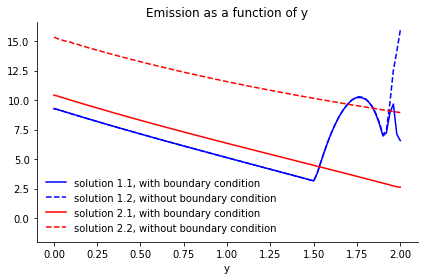

In [584]:
plt.plot(y_grid_cap, solution2['ems'], label="solution 1.1, with boundary condition", color="blue")
plt.plot(y_grid_cap, solution3['ems'], label="solution 1.2, without boundary condition ", color="blue",
        linestyle="dashed")

plt.plot(y_grid_cap, solution['ems'], label="solution 2.1, with boundary condition", color="red")
plt.plot(y_grid_cap, solution4['ems'], label="solution 2.2, without boundary condition",
        color="red", linestyle="dashed")
# plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:], label="continuation value function")
# plt.plot(ϕ_ref.T)
plt.ylim(-2)
plt.legend(loc=3)
plt.xlabel('y')
plt.title("Emission as a function of y")
plt.tight_layout()
# plt.savefig("../figures/20_damages/ems_match.png", facecolor="w", edgecolor="w", dpi=500)
plt.show()

In [469]:
dt = 1/4

In [470]:
def no_jump_simulation(ems, dt):
    y = 1.1
    T = 130
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    probt = np.zeros(T)
    for t in range(T):
#         if y < 1.5:
#             print(t)
        if y <= y_bar:
            e_i = np.interp(y, y_grid_cap, ems)
#             prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            probt[t] = 1-intensity*dt
            yt[t] = y
            y = y + e_i*np.mean(θ_list)*dt
#         else:
#             break
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    probt = probt[np.nonzero(probt)]

    return et, yt, probt

In [471]:
def no_jump_simulation_long(ems, dt):
    y = 1.1
    T = 130
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    probt = np.zeros(T)
    for t in range(T):
#         if y >= 1.5:
#             print(t)
#         if y < y_bar:
        e_i = np.interp(y, y_grid, ems)
        intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        prob_i = intensity*(intensity<1) + (intensity>=1)
        et[t] = e_i
        probt[t] = 1-prob_i
        yt[t] = y
        y = y + e_i*np.mean(θ_list)*dt
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    probt = probt[np.nonzero(probt)]

    return et, yt, probt

In [474]:
simul_no1 = no_jump_simulation(ems=solution['ems'], dt=1/4)

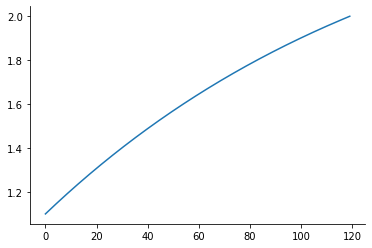

In [475]:
plt.plot(np.arange(0, len(simul_no1[1])*dt, dt), simul_no1[1])

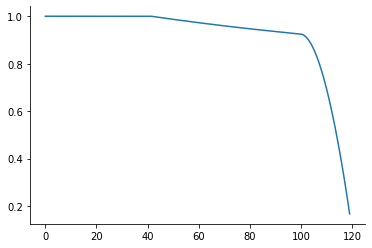

In [476]:
# year = np.arange(0, T-τ, τ)
plt.plot(np.arange(0, len(probt)*dt, dt), probt)
# plt.ylim(0)

In [477]:
len(ems_list), jump_interval[-1]

(26, 2.0000000000000004)

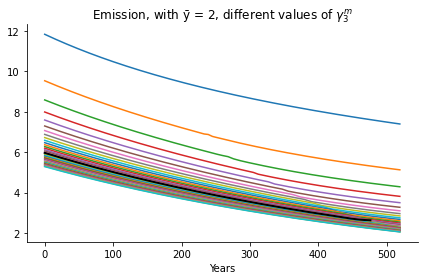

In [632]:
et_tests = []
for i in range(len(dmg_weight)):
    et_test, _, _ = no_jump_simulation_long(ems_list[-1, i], dt=1/4)
    plt.plot(et_test)
    et_tests.append(et_test)
    
plt.plot(simul_no1[0], color="black", linewidth=2)    
plt.xlabel('Years')
plt.title("Emission, with ȳ = 2, different values of $\gamma_3^m$")
plt.tight_layout()
# plt.xlim(0,3)
# plt.savefig("ems.pdf", facecolor="w", edgecolor="w")
plt.show()

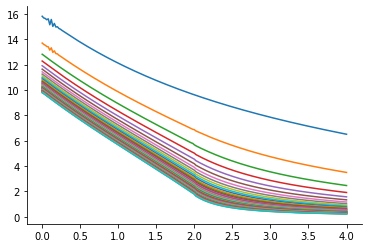

In [479]:
plt.plot(y_grid,ems_list[-1].T)
plt.show()

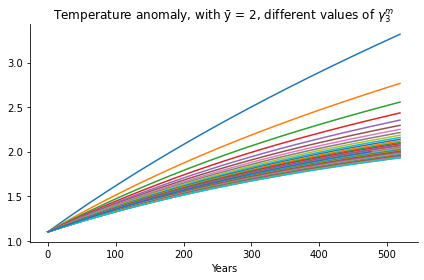

In [480]:
yt_refs = []
for i in range(len(dmg_weight)):
    _, yt_ref, _ = no_jump_simulation_long(ems_list[-1, i], dt=1/4)
    plt.plot(yt_ref, label="$\gamma2$")
    yt_refs.append(yt_ref)

# plt.legend()    
plt.plot(yt)
plt.xlabel('Years')
plt.title("Temperature anomaly, with ȳ = 2, different values of $\gamma_3^m$")

# plt.xlim(0,89)
plt.tight_layout()
# plt.savefig("Y.pdf", facecolor="w", edgecolor="w")
plt.show()

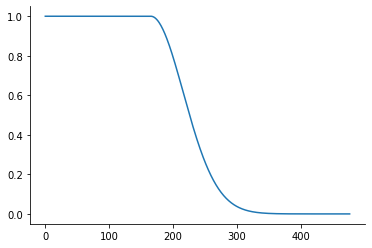

In [481]:
jump_prob = 1 - probt
integral = np.cumsum(jump_prob)
conti_prob = np.exp(- integral)
plt.plot(conti_prob)

In [487]:
prob_no_jump = np.cumprod(probt)
prob_no_jump.shape, yt.shape

((477,), (477,))

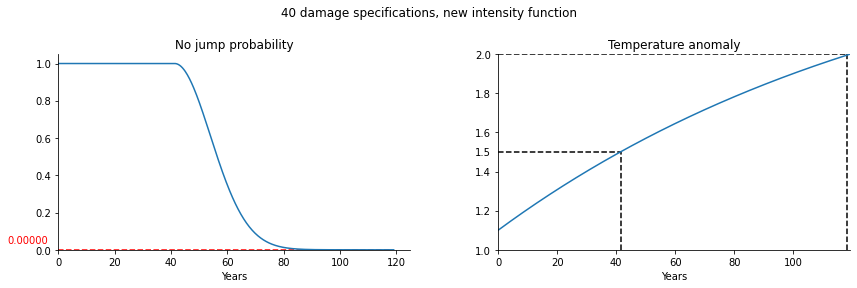

In [489]:
import matplotlib.transforms as transforms

T_jump = (np.abs(yt-1.5).argmin())*dt
T_stop = len(simul_no1[1])*dt

Years = np.arange(0, T_stop, dt)
prob_no_jump = np.cumprod(simul_no1[-1])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.suptitle('{} damage specifications, new intensity function'.format(len(dmg_weight)), y=0.99)


ax1.plot(Years, np.cumprod(simul_no1[-1]))
ax1.set_title("No jump probability")
ax1.set_xlabel('Years')
ax1.set_ylim(0)
ax1.set_xlim(0)
ax1.hlines(np.min(prob_no_jump), 0, T_stop-1, color="red", linestyle="dashed")
trans = transforms.blended_transform_factory(
    ax1.get_yticklabels()[0].get_transform(), ax1.transData)

ax1.text(-0.01,np.min(prob_no_jump)+0.05, "{:.05f}".format(np.min(prob_no_jump)), color="red", transform=trans, 
        ha="right", va="center")


ax2.plot(Years, simul_no1[1])
ax2.hlines(1.5, 0, T_jump, color="black", linestyle="dashed")
ax2.vlines(T_jump, 1, 1.5, color="black", linestyle="dashed" )
ax2.hlines(2, 0, T_stop-1, color="black", linestyle="dashed")
ax2.vlines(T_stop-1, 1, 2, color="black", linestyle="dashed" )
ax2.set_xlim(0, T_stop) 
ax2.set_title('Temperature anomaly')
ax2.set_xlabel('Years')
ax2.set_ylim(1,2)
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

ax1.text(0,1.5, 1.5, color="black", transform=trans, 
        ha="right", va="center")

fig.tight_layout()

# fig.savefig('prob_anomaly_new.png',dpi=500, facecolor="w", edgecolor="w")

In [490]:
T_jump

41.5

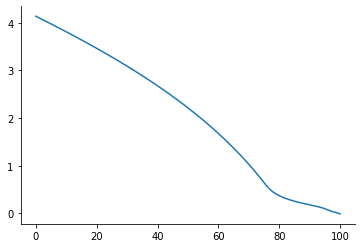

In [492]:
ϕ_list.shape
plt.plot(ϕ)

In [545]:
def jump_simulation(ems, dt):
    θ_mean = np.mean(θ_list)
#     ems = solution['ems']
#     ϕ=solution["φ"]
    ems_list = res_dict['ems_list']
    ϕ_list = res_dict['φ_list']
    y0 = 1.1
    y_lower = 1.5
    T_year = 120
    T = int(T_year/dt)
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    
    y = y0
    for t in range(T):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems)
#             prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            probt[t] = 1 - intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
        else:
            T_jump = t
            print(T_jump)
            break
    
    # get time span before 
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0
    for t in range(T):
        print(t)
        if y <= y_bar:
            e_i = np.interp(y, y_grid_cap, ems)
#             prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            probt[t] = 1- intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
    
    yt_nojump = yt[np.nonzero(yt)]
    et_nojump = et[np.nonzero(et)]
    
    T_final = len(yt_nojump)
    print(T_final)
    T_extra = T - T_final
    PROB = np.zeros((len(dmg_weight)*(T_final-T_jump)+1, T+1))
    EMS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    YS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    GS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0        
    for t in range(T_jump):
        print(t)
        e_i = np.interp(y, y_grid_cap, ems)
#         prob_i = r0*(np.exp(r1/2*(y - y_lower)**2) - 1)*(y > y_lower)

        intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        et[t] = e_i
        probt[t] = 1 - intensity*dt
        prob_no[t] = np.cumprod(probt[:t+1])[-1]
        yt[t] = y
        YS[:,t] = y
        PROB[:, t] = prob_no[t]
        EMS[:, t] = et[t]
        y = y + et[t]*θ_mean*dt
    
    
    
    
    for t in range(T_jump, T_final):
        print(t)
        if t == T_jump:
#             intensity = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)*(y > y_lower)
            
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            e_stay = np.interp(y, y_grid_cap, ems)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt

            for dmg in range(len(dmg_weight)):
                loc = np.abs(yt[t]-jump_interval).argmin()
                PROB[dmg+1, t] = intensity*dt*dmg_weight[dmg]
                EMS[dmg+1, t] = np.interp(yt[t], y_grid, ems_list[loc, dmg])
                YS[dmg+1, t] =  yt[t]
            
            for t_future in range(1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
                    PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]

#                 PROB[:, 0] = PROB[:,0]/np.sum(PROB[:,0])

            yt[t+1] = yt[t] + et[t]*θ_mean*dt   

        elif t > T_jump:
#             intensity = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)*(y > y_lower)
            intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            e_stay = np.interp(y, y_grid_cap, ems)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity*dt
            prob_no[: t+1] = np.cumprod(probt[:t+1])
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt

            for time in range(t-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + time*len(dmg_weight) +1
                    loc = np.abs(yt[time+T_jump]-jump_interval).argmin()
                    PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                    EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[loc, dmg])
                    YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

            for dmg in range(len(dmg_weight)):
                loc = np.abs(yt[t]-jump_interval).argmin()
                id_dmg = dmg + (t-T_jump)*len(dmg_weight) +1
                PROB[id_dmg, t] = PROB[0, t-1]*intensity*dt*dmg_weight[dmg]
            
                EMS[id_dmg, t] = np.interp(yt[t], y_grid, ems_list[loc, dmg])
                YS[id_dmg, t] = yt[t]
            
            for t_future in range(t-T_jump+1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
                    PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]
        
    for t in range(T_final, T+1):
        print(t)
        EMS[0, t] = EMS[0,t-1]
        probt[t] = 0
        prob_no[: t+1] = np.cumprod(probt[:t+1])
        PROB[0, t] = prob_no[t]
        YS[0, t] = y
        et[t] = et[t-1]
        yt[t] = y
        y = y + et[t]*θ_mean*dt
        for time in range(T_final-T_jump):
            for dmg in range(len(dmg_weight)):
                id_dmg = dmg + time*len(dmg_weight) +1
                loc = np.abs(yt[time+T_jump]-jump_interval).argmin()
                PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[loc, dmg])
                YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

    #                 PROB[:, DT] = PROB[:,DT]/np.sum(PROB[:,DT])

#     yt = yt[np.nonzero(yt)]
#     et = et[np.nonzero(et)]

    return et_nojump, yt_nojump, probt, prob_no, PROB, GS, YS, EMS

In [546]:
simul_full_1 = jump_simulation(solution['ems'], dt=1/4)

166
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

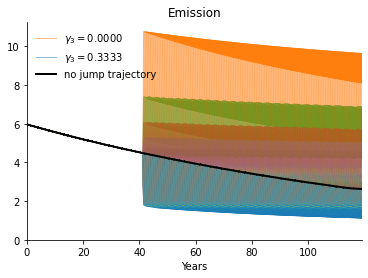

In [636]:
ems_test = simul_full_1[-1]


Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
color_palette = ["navy", "darkred", "darkorange", "forestgreen"]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    plt.plot(Time, ems_test[i, :Periods], 
#              color=colors[color_id],
             alpha=0.5, label=name, linewidth=1)
# plt.plot(simul_full_1[0])
plt.plot(Time, simul_no1[0], color="black", label="no jump trajectory", linewidth=2)
plt.ylim(0)
simul_full_1[-3][:,-1].sum()
# plt.plot(simul_full_1[-1].T)

plt.title("Emission")
plt.xlabel("Years")
plt.xlim(0, Time.max())
plt.legend(loc=2)
# plt.savefig("../figures/20_damages/emission_all_40.png",facecolor="w", edgecolor="w", dpi=500)

In [639]:
prob_110.max(), ems_test[:, Periods].argmax(), simul_full_1[-4][12401, Periods]

(0.0003594836334282265, 12401, 1.1214687751933956e-22)

In [615]:
ems_test[:, Periods].max()

9.627332411265066

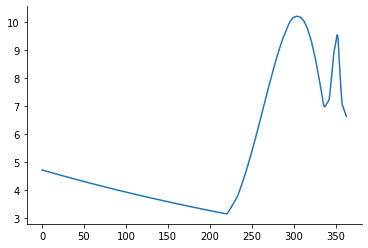

In [548]:
plt.plot(simul_no2[0])

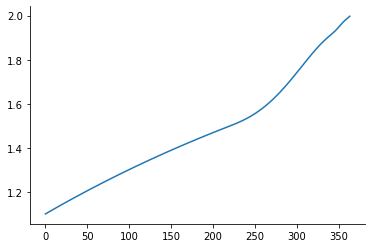

In [549]:
simul_no2 = no_jump_simulation(ems=solution2['ems'], dt=1/4)
plt.plot(simul_no2[1])

In [550]:
simul_full_2 = jump_simulation(ems=solution2['ems'], dt=1/4)

221
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

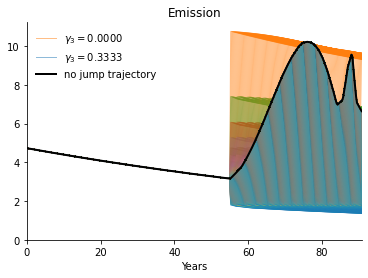

In [551]:
ems_test = simul_full_2[-1]
Periods = len(simul_full_2[0])
Time = np.arange(0, Periods*dt, dt)
color_palette = ["navy", "darkred", "darkorange", "forestgreen"]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    plt.plot(Time, ems_test[i, :Periods], 
#              color=colors[color_id],
             alpha=0.5, label=name, linewidth=1)
# plt.plot(simul_full_1[0])
plt.plot(Time, simul_no2[0], color="black", label="no jump trajectory", linewidth=2)
plt.ylim(0)
simul_full_1[-3][:,-1].sum()
# plt.plot(simul_full_1[-1].T)

plt.title("Emission")
plt.xlabel("Years")
plt.xlim(0, Time.max())
plt.legend(loc=2)
# plt.savefig("../figures/20_damages/emission_all_40.png",facecolor="w", edgecolor="w", dpi=500)

IndexError: index 2321 is out of bounds for axis 0 with size 2321

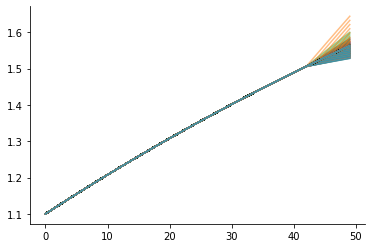

In [552]:
for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
    name = ""
    if int((i-1)/len(dmg_weight)) == 35-1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    plt.plot(solu[-2][i, :50], 
#              color=color_palette[color_id], 
             alpha=0.5, label=name)
plt.plot(yt, color="black", label="no jump trajectory", linewidth=2)
plt.title("Temperature anomaly")
plt.xlabel("Years")
plt.ylim(1.1, 3.2)
# plt.legend()
# plt.savefig("../figures/20_damages/tempanol_all.pdf", facecolor="w", edgecolor="w")

IndexError: index 2321 is out of bounds for axis 0 with size 2321

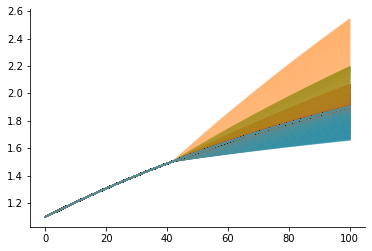

In [553]:
# 120
for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
    name = ""
    if int((i-1)/len(dmg_weight)) == 35-1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    plt.plot(solu[-2][i, :120], 
#              color=color_palette[color_id], 
             alpha=0.5, label=name)
plt.plot(yt, color="black", label="no jump trajectory", linewidth=2)
plt.title("Temperature anomaly")
plt.xlabel("Years")
plt.ylim(1.1, 3.2)
# plt.legend()
# plt.savefig("../figures/20_damages/tempanol_all.pdf", facecolor="w", edgecolor="w")

In [554]:
np.interp(3, y_grid_cap, ems_ref[0])

9.625855283479735

(0.0, 1.05)

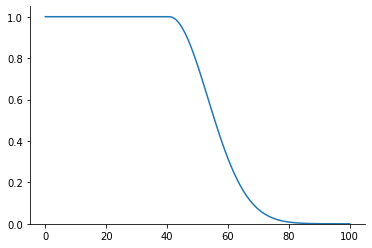

In [555]:
plt.plot(solu[3][:len(yt)])
plt.ylim(0)

In [556]:
solu[3]

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 9.95529315e-01, 9.84885087e-01,
       9.68269860e-01, 9.45994283e-01, 9.18467478e-01, 8.86184524e-01,
       8.49711722e-01, 8.09670101e-01, 7.66717954e-01, 7.21533031e-01,
       6.74795044e-01, 6.27169152e-01, 5.79290896e-01, 5.31753082e-01,
      

In [557]:
solu[3], solu[-2][1], solu[-2][21], (1 - 0.99989311/0.99999407)/20
prob_test = solu[-4][:,100]

prob_test.sum()

0.9999715834206131

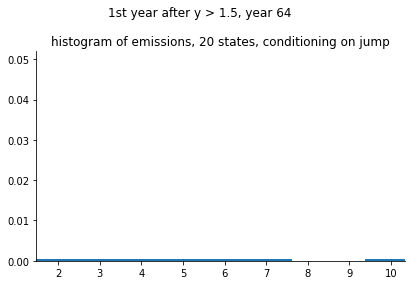

In [558]:
ems1 = solu[-1][:,65]
ems1 = ems1[np.nonzero(ems1)]
y1 = solu[-3][:,65]
y1 = y1[np.nonzero(y1)]
prob1 = solu[-2][:, 65]
prob1 = prob1[np.nonzero(prob1)]

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("1st year after y > 1.5, year 64")
axes.bar(ems1[1:], height=prob1[1:]/np.sum(prob1[1:]))
axes.set_xlim(np.min(ems1), np.max(ems1))
# axes[1].bar(y1[1:], height=prob1[1:]/np.sum(prob1[1:]))


axes.set_title("histogram of emissions, 20 states, conditioning on jump")
# axes[1].set_title("histogram of temperature anomaly, 20 states")
fig.tight_layout()
axes.set_ylim(0, 0.052)
axes.set_xlim(np.min(ems1), np.max(ems1))
# plt.savefig("histogram_1.png", facecolor="w", edgecolor="w")
plt.show()

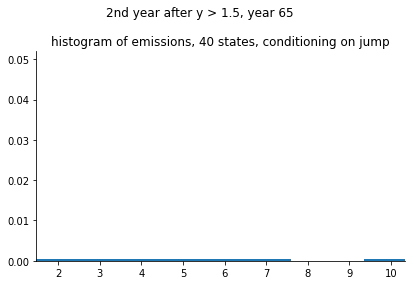

In [321]:
ems2 = solu[-1][:,66]
ems2 = ems2[np.nonzero(ems2)]
y2 = solu[-3][:, 66]
y2 = y2[np.nonzero(y2)]
prob2 = solu[-2][:, 66]
prob2 = prob2[np.nonzero(prob2)]

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("2nd year after y > 1.5, year 65")
axes.bar(ems2[1:], height=prob2[1:]/np.sum(prob2[1:]))
# axes[0].set_xlim(np.)
# axes.bar(y2[1:], prob2[1:]/np.sum(prob2[1:]) )
axes.set_xlim(np.min(ems1), np.max(ems1))
axes.set_title("histogram of emissions, 40 states, conditioning on jump")
# axes.set_title("histogram of temperature anomaly, 41 states")
fig.tight_layout()
axes.set_ylim(0, 0.052)
# axes[1].set_xlim(1.5, 1.8)
# plt.savefig("histogram_2.png", facecolor="w", edgecolor="w")
plt.show()

In [322]:
len(yt)

119

In [561]:
t = len(yt)-1
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

IndexError: index 476 is out of bounds for axis 1 with size 101

In [562]:
y_110[0], yt[-1], prob_110.sum()

(1.999289770184682, 1.999289770184682, 3.9995002089386094)

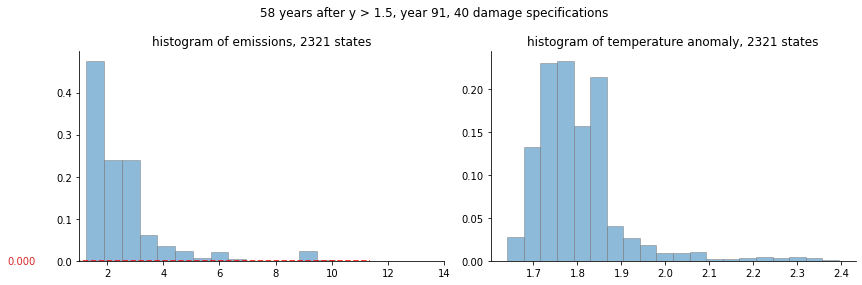

In [325]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)
t = 91
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications".format(int((len(ems_110)-1)/len(dmg_weight)),t, len(dmg_weight)))
axes[0].hist(ems_110, weights=prob_110, 
             bins=np.linspace(0, 12, 20), 
             alpha=0.5, ec="gray")
axes[1].hist(y_110, weights=prob_110, 
#              bins=np.linspace(1.6, 3.2, 40),
             bins=20,
             density=False, alpha=0.5, ec="gray")

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)

p = axes[0].patches

distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_height()

bins = np.array([patch.get_xy()[0] for patch in p])
axes[0].hlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
axes[0].text(-0.1,distribution[-1], "{:.3f}".format(distribution[-1]), color="tab:red", transform=trans, 
        ha="right", va="center")
# no jump
# axes[0].hlines(distribution[np.nonzero(distribution)][-2], 0, bins[np.nonzero(distribution)][-2], color="green", linestyle="dashed")
# axes[0].text(-0.1,distribution[np.nonzero(distribution)][-2], "{:.3f} (no jump)".format(distribution[np.nonzero(distribution)][-2]), 
#              color="green", transform=trans, 
#         ha="right", va="center")
axes[0].set_xlim(1,14)
# axes[1].set_xlim(1.6, 3.2)
# axes[1].set_ylim(0,0.25)
# axes[0].set_ylim(0,0.25)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
# plt.savefig("histogram_new.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

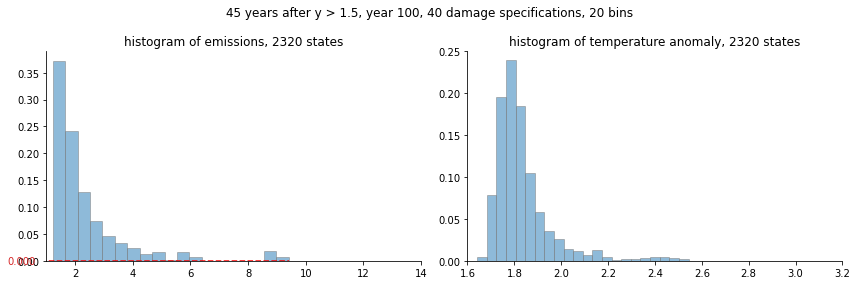

In [326]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

t = 100
ems_110 = solu[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = solu[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = solu[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]



fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications, 20 bins".format(t-55, t, len(dmg_weight)))
axes[0].hist(ems_110[1:], weights=prob_110[1:], bins=20,ec="gray", alpha=0.5)
axes[1].hist(y_110[1:], weights=prob_110[1:], bins=np.linspace(1.6, 3.2, 40), ec="gray", alpha=0.5)

p = axes[0].patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_height()
bins = np.array([patch.get_xy()[0] for patch in p])

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)
axes[0].hlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
axes[0].text(-0.01,distribution[-1], "{:.3f}".format(distribution[-1]), color="tab:red", transform=trans, 
        ha="right", va="center")

axes[0].set_xlim(1,14)
axes[1].set_xlim(1.6,3.2)

axes[1].set_ylim(0,0.25)
# axes[0].set_ylim(0,0.25)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)-1))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)-1))
fig.tight_layout()
# plt.savefig("histogram_new_100.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

In [544]:
prob_110.sum()

3.9995002089386094

In [590]:
ems_110.max()

9.629877124193415

(array([4.05265392e-01, 2.35199906e-01, 1.21561860e-01, 7.22603914e-02,
        4.01229651e-02, 2.79367291e-02, 2.21715486e-02, 2.14729382e-02,
        3.98064802e-03, 6.34327134e-03, 1.79984609e-02, 6.81144397e-04,
        4.74513217e-06, 3.62589153e-12, 0.00000000e+00, 0.00000000e+00,
        1.40461567e-02, 1.07414508e-02, 2.11549079e-04, 8.43410072e-07]),
 array([1.12819351, 1.55327769, 1.97836187, 2.40344606, 2.82853024,
        3.25361442, 3.6786986 , 4.10378278, 4.52886696, 4.95395114,
        5.37903532, 5.8041195 , 6.22920368, 6.65428786, 7.07937204,
        7.50445622, 7.9295404 , 8.35462458, 8.77970876, 9.20479294,
        9.62987712]),
 <BarContainer object of 20 artists>)

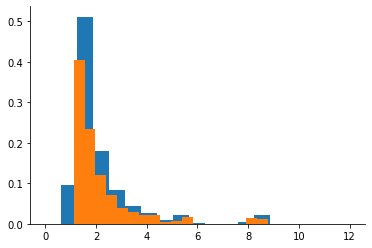

In [623]:
ems_test = simul_full_1[-1]
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_no1[0])-1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]

plt.hist(ems_test[:, t], weights=prob_110, bins=np.linspace(0,12,20))
plt.hist(ems_110, weights=prob_110, bins=20)

In [610]:
ems_test = simul_full_1[-1]
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_no1[0])
ems_110 = simul_full_1[-1][:, t]
ems_test[:, t].max(), ems_110.max(), Periods, ems_test[41]

(9.627332411265066,
 9.627332411265066,
 477,
 array([ 5.96591883,  5.95552803,  5.94515533,  5.9348007 ,  5.9244641 ,
         5.9141455 ,  5.90384488,  5.89356219,  5.88330641,  5.87307133,
         5.86285405,  5.85265455,  5.84247279,  5.83230875,  5.82216238,
         5.81203823,  5.80193782,  5.79185497,  5.78178964,  5.77174181,
         5.76171143,  5.75169849,  5.74170295,  5.73173433,  5.72178305,
         5.71184905,  5.70193229,  5.69203275,  5.6821504 ,  5.6722852 ,
         5.66244114,  5.65261865,  5.6428132 ,  5.63302475,  5.62325329,
         5.61349878,  5.60376118,  5.59404048,  5.58434292,  5.57466332,
         5.56500049,  5.55535441,  5.54572506,  5.53611239,  5.52651639,
         5.51693777,  5.50738138,  5.49784154,  5.48831823,  5.47881142,
         5.46932107,  5.45984716,  5.45038966,  5.44095008,  5.43153067,
         5.42212757,  5.41274075,  5.40337018,  5.39401583,  5.38467768,
         5.37535569,  5.36605135,  5.35676597,  5.34749666,  5.33824339,
     

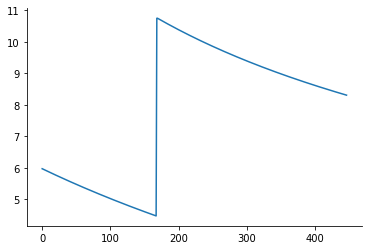

In [602]:
plt.plot(ems_test[81, :447])

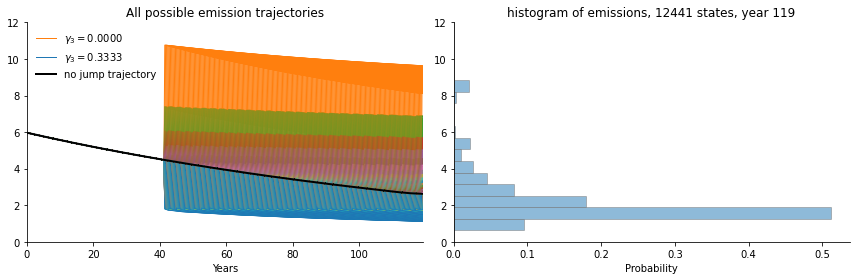

In [619]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4)) 

ems_test = simul_full_1[-1]
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_no1[0])-1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    ax1.plot(Time, ems_test[i, :Periods], 
#              color=colors[color_id],
             alpha=1, label=name, linewidth=1)


ax1.plot(Time, simul_no1[0], color="black", label="no jump trajectory", linewidth=2)
ax1.set_ylim(0)

ax1.set_title("All possible emission trajectories")
ax1.set_xlabel("Years")
ax1.set_xlim(0, len(simul_full_1[0])*dt)
ax1.legend()

# plot2


ax2.hist(ems_110, weights=prob_110, 
         bins=np.linspace(0,12,20),
         alpha=0.5,
         orientation="horizontal", ec="gray")
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

p = ax2.patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_width()
bins = np.array([patch.get_xy()[-1] for patch in p])


# ax2.set_xlim(1,14)
ax2.set_ylim(0,12)
ax1.set_ylim(0,12)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
ax2.set_title("histogram of emissions, {} states, year 119".format(len(ems_110)))
ax2.set_xlabel("Probability")
fig.subplots_adjust(wspace=-1)
fig.tight_layout()
plt.savefig("../figures/20_damages/emission_hist_1.png",facecolor="w", edgecolor="w", dpi=500)

In [586]:
len(simul_full_2[0])/4

91.0

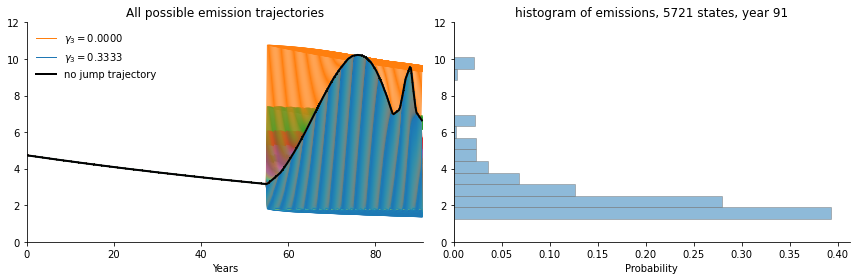

In [629]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4)) 

ems_test = simul_full_2[-1]
Periods = len(simul_full_2[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_no2[0])-1
ems_110 = simul_full_2[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_2[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_2[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
#     print(i, color_id, int((i-1)/len(dmg_weight)))
    name = ""
    if color_id == 0 and int((i-1)/len(dmg_weight))==0:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    elif color_id == len(dmg_weight)-1 and int((i-1)/len(dmg_weight))==1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
#     if color_id == 0 or color_id == 1:
    ax1.plot(Time, ems_test[i, :Periods], 
#              color=colors[color_id],
             alpha=1, label=name, linewidth=1)
# ax1.plot(simul_full_2[0])
ax1.plot(Time, simul_no2[0], color="black", label="no jump trajectory", linewidth=2)
ax1.set_ylim(0)

ax1.set_title("All possible emission trajectories")
ax1.set_xlabel("Years")
ax1.set_xlim(0, len(simul_full_2[0])*dt)
ax1.legend()

# plot2


ax2.hist(ems_110, weights=prob_110, 
         bins=np.linspace(0,12,20),
         alpha=0.5,
         orientation="horizontal", ec="gray")
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

p = ax2.patches
distribution = np.zeros(len(p))
for i in range(len(p)):
    distribution[i] = p[i].get_width()
bins = np.array([patch.get_xy()[-1] for patch in p])

# ax2.vlines(distribution[-1], 0, bins[-1], color="red", linestyle="dashed")
# ax2.text(distribution[-1] + 0.05, -1.5, "{:.3f}".format(distribution[-1]), color="red", transform=trans, 
#         ha="center", va="center")


# ax2.vlines(distribution[np.nonzero(distribution)][-2], -0.05, bins[np.nonzero(distribution)][-2], color="green", linestyle="dashed")
# ax2.text(distribution[np.nonzero(distribution)][-2]+0.03, -2.2, 
#          "{:.3f} (no jump)".format(distribution[np.nonzero(distribution)][-2]), 
#              color="green", transform=trans, 
#         ha="center", va="center")

# ax2.set_xlim(1,14)
ax2.set_ylim(0,12)
ax1.set_ylim(0,12)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
ax2.set_title("histogram of emissions, {} states, year 91".format(len(ems_110)))
ax2.set_xlabel("Probability")
fig.subplots_adjust(wspace=-1)
fig.tight_layout()
plt.savefig("../figures/20_damages/emission_hist_2.png",facecolor="w", edgecolor="w", dpi=1000)

In [212]:
indices_mat = np.zeros((len(dmg_weight), int( (len(ems_110)-1)/len(dmg_weight))), dtype=int)
for i in range(len(dmg_weight)):
    count = 0
    for j in range(1,len(ems_110)):
        if (j-1)%len(dmg_weight) == i:
            indices_mat[i,count] = j
            count += 1

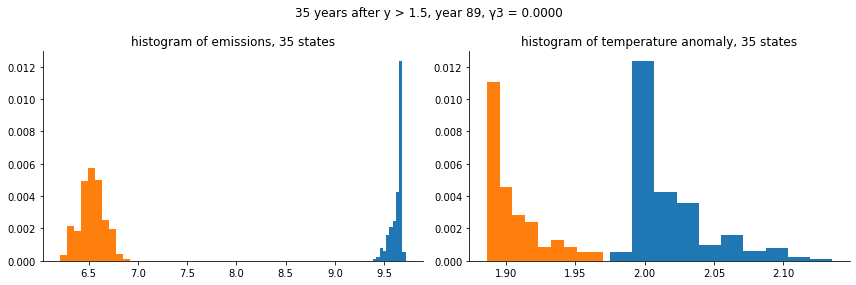

In [213]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

i = 0
fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, γ3 = {:.4f}".format(int((len(ems_110)-1)/len(dmg_weight)),len(yt)-1, γ3_list[i]))
axes[0].hist(ems_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10)
axes[0].hist(ems_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10)
axes[1].hist(y_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10, density=False)
axes[1].hist(y_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10, density=False)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110[indices_mat[i]])))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110[indices_mat[i]])))
fig.tight_layout()
# plt.savefig("histogram_{}_tight.png".format(i), facecolor="w", edgecolor="w", dpi=500)
# plt.show()

In [ ]:
np.abs(distribution).argmax()

In [ ]:
bins[2], bins[3]

In [ ]:
in_the_bin = np.where((ems_110 >= bins[2] )& (ems_110 < bins[3]))[0]

In [ ]:
(in_the_bin-1)/40

In [ ]:
y_110_1 = y_110[1:]
y_large = y_110_1[y_110_1>=1.95]
y_small = y_110_1[y_110_1<1.95]


ems_110_1 = ems_110[1:]
ems_large = ems_110_1[y_110_1>=1.95]
ems_small = ems_110_1[y_110_1<1.95]
prob_110_1 = prob_110[1:]
prob_large = prob_110_1[y_110_1 >= 1.95]
prob_small = prob_110_1[y_110_1 < 1.95]

In [ ]:
prob_large.argmax(), prob_large[30:33], y_large[30:33]

In [ ]:
plt.bar(y_large, prob_large, width=0.005)

In [ ]:
np.where(solu[-3][:,110] ==  y_large[31])[0][0]

In [ ]:
(1241-1)/40

In [ ]:
yt[-1], y_110[1121]

In [ ]:
prob_small.argmax(), prob_small[1209], y_small[1209]

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(y_small, prob_small, width=0.005, color="tab:blue", alpha=0.1)
plt.bar(y_small[1209:1209+39], prob_small[1209:1209+39], color="black", width=0.002, label="peaks")

plt.bar(y_large, prob_large, width=0.004, color="tab:red", alpha=0.5)
plt.bar(y_large[31], prob_large[31], width=0.005, color="black")
plt.hlines(prob_small[1209], xmin=np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")

plt.annotate("Jump occurs 31 years after y > 1.5,\n to each damage specification with probability .00107",
            xytext=(2.1,0.001-0.001/5), xy=(2.1, prob_large[31]),
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))

plt.annotate("Lowest damage specification ($\gamma_3^m = 0$)",
            xy=(y_large[31],0.001/2), xytext=(y_large[31]+0.1,0.001/2), 
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3),)

plt.title('Temperature anomaly')
plt.ylabel("Probability")
plt.legend(loc=(0.01,0.8))
plt.tight_layout()
# plt.savefig("../figures/20_damages/tempanol_46.pdf", facecolor="w", edgecolor="w")

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(ems_small, prob_small, width=0.05, color="tab:blue", alpha=0.1)
plt.bar(ems_small[1209:1209+39], prob_small[1209:1209+39], color="black", width=0.01, label="peaks")

plt.bar(ems_large, prob_large, width=0.01, color="tab:red", alpha=0.5)
plt.bar(ems_large[31], prob_large[31], width=0.05, color="black")
plt.hlines(prob_small[1209], xmin=np.min(ems_110), xmax=np.max(ems_110), linestyle="dashed", color="black")

plt.annotate("Jump occurs 31 years after y > 1.5,\n to each damage specification with probability .00107",
            xytext=(10,prob_large[31]-0.0002),
            xy=(10,prob_large[31]),
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))

plt.annotate("Lowest damage specification",
            xy=(ems_large[31],0.001/2), xytext=(ems_large[31]+ 1,0.001/2), 
            arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3),)

plt.title('Emissions')
plt.ylabel('Probability')
plt.legend(loc=(0.8,0.1), frameon=False)
plt.tight_layout()
# plt.savefig("../figures/20_damages/ems_46.pdf", facecolor="w", edgecolor="w")

In [ ]:
1/40

In [ ]:
np.where(solu[-3][:,110] ==  y_small[1209])[0][0]

In [ ]:
(1242-1)/40

In [ ]:
prob_110[31*40+1:32*40+2], prob_small[1209:1209+40]

In [ ]:
plt.plot(intensity)

In [ ]:
indice_ems = np.argsort(ems_110_1)
ems_sort = ems_110_1[indice_ems]
prob_sort = prob_110_1[indice_ems]

In [ ]:
@njit
def simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, y_start =1.1,  T=86, dt=1):
    tspan  = int(T/dt)
    ems_grid_realize = ems_pre
    et = np.zeros(tspan)
    yt = np.zeros(tspan)
    state_t = np.zeros(tspan)
    y = y_start
    # flag
    jumped = False
    for t in range(tspan):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems_grid_realize)
            et[t] = e_i
            yt[t] = y
            state_t[t] = 0
            y = y + e_i*θ
            
        elif y >= y_lower and jumped == False:
#             print(t)
            intensity_i = r0*(np.exp(r1/2*(y-y_lower)**2) - 1)
            jump = np.random.binomial(1, intensity_i)
            if jump == 1:
                jumped = True
                dmg_realization = np.random.multinomial(1, pvals=dmg_weight)
                loc = np.abs(y-jump_interval).argmin()
                damage_type = np.argwhere(dmg_realization==1)
                ems_grid_realize = ems_list[loc, damage_type[0][0]]
                state_t[t] = 1 + damage_type[0][0]
                et[t] = np.interp(y, y_grid, ems_grid_realize)
            elif jump == 0:
                et[t] = np.interp(y, y_grid_cap, ems_grid_realize)
                state_t[t] = 0
            yt[t] = y
            y = y + et[t]*θ
        elif y>=y_lower and jumped  == True:
            et[t] = np.interp(y, y_grid, ems_grid_realize)
            state_t[t] = state_t[t-1]
            yt[t] = y
            y = y + et[t]*θ
    return yt, et, state_t

In [ ]:
@njit
def simulate_path(y_grid_cap, ems_pre, ems_ref, θ, T, N=1_000_000):
    Yt = np.zeros((N, T))
    Et = np.zeros((N, T))
    Statet = np.zeros((N, T))
    for s in range(N):
        np.random.seed(s)
        yt, et, state_t = simulate_ems(y_grid_cap, ems_pre, ems_ref, θ, T=T)
        Yt[s] = yt
        Et[s] = et
        Statet[s] = state_t
    return Yt, Et, Statet

In [ ]:
Yt, Et, Statet = simulate_path(y_grid_cap, solution['ems'], ems_ref, np.mean(θ_list), len(yt))

In [ ]:
et_100 = Et[:,len(yt)-1]
yt_100 = Yt[:,len(yt)-1]

In [ ]:
plt.hist(yt_100, weights =np.ones_like(yt_100)/len(yt_100),  bins=50)
plt.show()

In [ ]:
plt.hist(et_100, weights =np.ones_like(et_100)/len(et_100),  bins=50)
plt.show()

In [ ]:
Yt[:,-1]

In [ ]:
for i in range(len(Et)):
    plt.plot(Et[i])
plt.show()

In [ ]:
len(et_100[et_100==0])

In [ ]:
np.unique(et_100).shape

In [ ]:
np.unique(yt_100[Statet[:,-1]==20]).shape, np.unique(yt_100[Statet[:,-1]==10]).shape

In [ ]:
np.median(γ3_list)

In [ ]:
# emission
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("emission histogram for two of the $\gamma_3$, year 100")
ax1.hist(et_100[Statet[:,78]==4], 
         bins=20, weights=np.ones(len(et_100[Statet[:,78]==4]))/len(et_100[Statet[:,78]==4]))
ax1.set_ylim(0,0.14)
ax1.set_title("γ3 = 0, 35 states")
# ax1.set_xlim(1.2,1.72)
ax2.hist(yt_100[Statet[:,78]==4], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,78]==4]))/len(yt_100[Statet[:,78]==4]))
ax2.set_ylim(0,0.14)
ax2.set_title('γ3 = 0.7706 (extreme damage), 35 states')
fig.tight_layout()
# plt.savefig('histogram_e.pdf')

In [ ]:
# Y
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
fig.suptitle("temperature anomaly histogram for two of the $\gamma_3$, year 100")
ax1.hist(yt_100[Statet[:,-1]==10], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,-1]==10]))/len(yt_100[Statet[:,-1]==10]))
ax1.set_ylim(0,0.14)
ax1.set_title("γ3 = 0.3650, 35 states")
# ax1.set_xlim(1.2,1.72)
ax2.hist(yt_100[Statet[:,-1]==20], 
         bins=20, weights=np.ones(len(yt_100[Statet[:,-1]==20]))/len(yt_100[Statet[:,-1]==20]))
ax2.set_ylim(0,0.14)
ax2.set_title('γ3 = 0.7706 (extreme damage), 35 states')
fig.tight_layout()
# plt.savefig('histogram_y.pdf')

In [ ]:
plt.hist(et_100[Statet[:,-1]==10])

In [ ]:
plt.hist(Yt[:,-1], bins=100, density=False)
plt.show()

In [ ]:
len(np.unique(Et[:,-1]))

In [ ]:
e_select = Et[np.where(Statet[:, 60]==), 80]

In [ ]:
weights = np.ones_like(e_select.flatten()) / len(e_select.flatten())
plt.hist(e_select.flatten(), weights=weights, bins=20)

In [ ]:
et_10 = np.percentile(Et, 10, axis=0)
et_50 = np.percentile(Et, 50, axis=0)
et_90 = np.percentile(Et, 90, axis=0)

In [ ]:
plt.plot(et_10, label='.1 percentile')
plt.plot(et_50, label='.5 percentile')
plt.plot(et_90, label='.9 percentile')
plt.plot(et_10[:50])
plt.vlines(50, ymin=0, ymax=np.max(et_90), color="black", linestyle="dashed")
plt.ylim(0)
plt.title('Emission')